<a href="https://colab.research.google.com/github/connect-midhunr/rossmann-sales-prediction/blob/main/Rossmann_Sales_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# Business Task

Analyse the historical sales data for 1,115 Rossmann stores and build a machine learning model to forecast the sales of each Rossmann store upto 6 weeks. 

# Importing Libraries and Defining Functions

In [1]:
# importing all relevant python libraries
import warnings
warnings.filterwarnings("ignore")

import math
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import pickle

In [2]:
# define a function to find the number and percentage of missing values in a dataframe
def get_missing_values_count_and_percentage(dataframe):
  num = 0
  for column in dataframe.columns:
    count = dataframe[column].isnull().sum()
    percentage = count/dataframe.shape[0]*100
    if percentage > 0:
      num += 1
      print(f"{column}: {count}({round(percentage, 2)})%")
  if num == 0:
    print("No missing values in the dataframe")

In [3]:
# define a function to calculate the upper and lower outlier boundary
# returns a tuple (upper_outlier_bound, lower_outlier_bound)
def get_outlier_boundaries(dataframe, column):
  percentile_25 = np.nanpercentile(dataframe[column],25)
  percentile_75 = np.nanpercentile(dataframe[column],75)
  iqr = (percentile_75 - percentile_25)
  upper_outlier_bound = percentile_75 + 1.5*iqr
  lower_outlier_bound = percentile_25 - 1.5*iqr

  return (upper_outlier_bound, lower_outlier_bound)

# define a function to calculate the number and percentage of outliers in a column
# returns a tuple (count, percentage)
def get_outlier_count_and_percentage(dataframe, column):
  # print(dataframe.shape[0])
  upper_outlier_bound, lower_outlier_bound = get_outlier_boundaries(dataframe, column)

  count = 0
  for value in dataframe[column]:
    if value > upper_outlier_bound or value < lower_outlier_bound:
      count += 1
  percentage = round(count/dataframe.shape[0]*100, 2)

  return (count, percentage)

In [4]:
# define a function to get count of each unique value from a particular column 
# returns a dataframe
def get_count_from_column(dataframe, column_label):
  df_grpd = dataframe[column_label].value_counts()
  df_grpd = pd.DataFrame({'index':df_grpd.index, 'count':df_grpd.values})
  return df_grpd

# define a function to get sum of a certain feature for each unique value from a particular column 
# returns a dataframe
def get_sum_from_column(dataframe, column_label, feature):
  df_grpd = dataframe.groupby(column_label)[feature].sum().reset_index(name=feature)
  return df_grpd

In [5]:
# define a function to calculate the vif of all features
# returns a dataframe
def calculate_vif_of_all_features(dataframe):
  temp_df = pd.DataFrame()
  temp_df['Feature'] = dataframe.columns
  temp_df['VIF'] = [variance_inflation_factor(dataframe.values, column_index) for column_index in range(dataframe.shape[1])]

  return temp_df

In [6]:
# define a function to calculate root mean squared percentage error
# returns an array
def calculate_rmspe(y_actual, y_pred):
  return (np.sqrt(np.mean(np.square(y_actual.to_numpy() - y_pred))) / np.mean(y_actual.to_numpy())) * 100

In [7]:
# define a function to calculate metrics
# returns a dictionary
def calculate_model_metrics(y_train, y_train_pred, y_test, y_test_pred):
  metrics_dict = {}

  metrics_dict['Train_R2'] = r2_score(y_train, y_train_pred)
  metrics_dict['Test_R2'] = r2_score(y_test, y_test_pred)
  metrics_dict['Train_RMSE'] = mean_squared_error(y_train, y_train_pred, squared=False)
  metrics_dict['Test_RMSE'] = mean_squared_error(y_test, y_test_pred, squared=False)
  metrics_dict['Train_RMSPE'] = calculate_rmspe(y_train, y_train_pred)
  metrics_dict['Test_RMSPE'] = calculate_rmspe(y_test, y_test_pred)

  return metrics_dict

In [8]:
# define a function to generate horizontal box plot
# prints a box plot
def generate_horizontal_box_plot(dataframe, x_feature, y_feature=None):
  sns.set_theme(rc={'figure.figsize': (8,4)},style='whitegrid',palette='muted')
  if y_feature != None:
    ax = sns.boxplot(x=dataframe[x_feature], y=dataframe[y_feature])
  else:
    ax = sns.boxplot(x=dataframe[x_feature], y=None)
  ax.grid(False)

# define a function to generate vertical box plot
# prints a box plot
def generate_vertical_box_plot(dataframe, y_feature, x_feature=None):
  sns.set_theme(rc={'figure.figsize': (4,8)},style='whitegrid',palette='muted')
  if x_feature != None:
    ax = sns.boxplot(y=dataframe[y_feature], x=dataframe[x_feature])
  else:
    ax = sns.boxplot(y=dataframe[y_feature], x=None)
  ax.grid(False)

In [9]:
# generate density plots of a feature in a dataframe
# prints a density plot
def density_plot_of_a_feature(dataframe, feature):
  plt.figure(figsize=(8, 6))
  sns.distplot(dataframe[feature])
  plt.show()

# generate density plots of all features in a dataframe
# prints density plots
def density_plot_of_all_features(dataframe):
  columns = dataframe.describe().columns.tolist()

  columns_num = 3
  rows_num = math.ceil(len(columns)/columns_num)
  fig, axes = plt.subplots(rows_num, columns_num, figsize=(10*columns_num, 8*rows_num))

  row = -1
  column = columns_num - 1
  for feature in columns:
    if column == (columns_num - 1):
      row += 1
      column = 0
    else:
      column += 1
    sns.distplot(ax=axes[row, column], a=dataframe[feature])
    axes[row, column].set_title(f"{feature} Distribution")
  
  if len(columns) % columns_num != 0:
    for column_num in range(column + 1, columns_num):
      fig.delaxes(axes[rows_num - 1][column_num])

In [10]:
# define a function to plot scatter plot between two features with regression line
# prints a scatter plot with regression line
def scatter_plot_with_regression_line(dataframe, x_feature, y_feature):
  plt.figure(figsize=(6,6))
  sns.scatterplot(x=x_feature, y=y_feature, data=dataframe)

  lin_fit = np.polyfit(dataframe[x_feature], dataframe[y_feature], 1)
  lin_func = np.poly1d(lin_fit)(dataframe[x_feature])
  plt.plot(dataframe[x_feature], lin_func, "r--", lw=1)

  plt.title(f"Correlation between {x_feature} and {y_feature}: {round(dataframe[x_feature].corr(dataframe[y_feature])*100, 2)}%")

In [11]:
# define a function to plot bar graph with two features
# prints a bar graph
def plot_bar_graph_with_two_features(dataframe, x_feature, y_feature):
  if type(y_feature) == list:
    size = len(y_feature)
    fig, axes = plt.subplots(1, size, figsize=(10*size, 6))
    column = -1
    for feature in y_feature:
      column += 1
      sns.barplot(ax=axes[column], x=dataframe[x_feature], y=dataframe[feature], estimator=sum)
      axes[column].set_title(f"Sum of {feature} vs {x_feature}")
  else:
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=dataframe[x_feature], y=dataframe[y_feature], estimator=sum)
    ax.set_title(f"Sum of {y_feature} vs {x_feature}")
    plt.show()

In [12]:
# define a function to plot bar graph with three features
# prints a bar graph
def plot_bar_graph_with_three_features(dataframe, x_feature, y_feature, z_feature, y_label):
  plt.figure(figsize=(20, 10))

  X = dataframe[x_feature].tolist()
  Y = dataframe[y_feature].tolist()
  Z = dataframe[z_feature].tolist()
    
  X_axis_length = np.arange(len(X))
    
  plt.bar(X_axis_length - 0.2, Y, 0.4, label = y_feature)
  plt.bar(X_axis_length + 0.2, Z, 0.4, label = z_feature)
  
  min_limit = 0.9 * min(dataframe[y_feature].min(), dataframe[z_feature].min())
  max_limit = 1.1 * max(dataframe[y_feature].max(), dataframe[z_feature].max())
  plt.ylim(min_limit, max_limit)
    
  plt.xticks(X_axis_length, X)
  plt.xlabel(x_feature)
  plt.ylabel(y_label)
  plt.legend()
  plt.show()

In [13]:
# define a function to plot line graph with dot markers over time
# prints a line graph
def plot_line_graph_with_two_features_over_time(dataframe, x_feature, y_feature, time, title):
  # unique year values in time
  times = dataframe[time].unique().tolist()

  # list of random colors to use in the graph
  num_of_colors = len(times)
  list_of_colors = color=["#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)])
                                                                         for j in range(num_of_colors)]
  # plot each line graph                                                                       
  color_num = -1
  plt.figure(figsize=(24, 6))
  for ind_time in times:
    color_num += 1
    temp_df = dataframe[dataframe[time] == ind_time]
    temp_df = temp_df.groupby(x_feature)[y_feature].sum().reset_index()
    plt.plot(temp_df.loc[:,y_feature], label=ind_time, color=list_of_colors[color_num], marker='o')
    plt.xticks(range(1, dataframe[x_feature].max() + 1))
  plt.title(f'{title} {y_feature} Over {time}s')
  plt.legend()

In [14]:
# generate scatter plots to check the linearity between sales and customers for each unique value in a feature
# plots scatter plots
def scatter_plot_bw_sales_customers_with_feature_unique_values(dataframe, feature):
  unique_values = sorted(dataframe[feature].unique().tolist())

  columns_num = 2
  rows_num = math.ceil(len(unique_values)/columns_num)
  fig, axes = plt.subplots(rows_num, columns_num, figsize=(10*columns_num, 8*rows_num))

  row = -1
  column = columns_num - 1
  for unique_value in unique_values:
    if column == (columns_num - 1):
      row += 1
      column = 0
    else:
      column += 1
    temp_df = dataframe[dataframe[feature] == unique_value]
    sns.scatterplot(ax=axes[row, column], x='Customers', y='Sales', data=temp_df)
    lin_fit = np.polyfit(temp_df['Customers'], temp_df['Sales'], 1)
    lin_func = np.poly1d(lin_fit)(temp_df['Customers'])
    axes[row, column].plot(temp_df['Customers'], lin_func, "r--", lw=1)
    axes[row, column].set_title(f"Sales vs Customers for {unique_value}\nCorrelation = {round(temp_df['Customers'].corr(temp_df['Sales'])*100, 2)}%")
  
  if len(unique_values) % columns_num != 0:
    for column_num in range(column + 1, columns_num):
      fig.delaxes(axes[rows_num - 1][column_num])

# Data Reading

In [15]:
# creating dataframes and store csv data

path = '../data/store.csv'
store_df = pd.read_csv(path, index_col=0)
path = '../data/Rossmann Stores Data.csv'
sales_df = pd.read_csv(path, index_col=0)

# Data Inspection

Two datasets are given: store data and sales data. These two datasets should be merged after data cleaning and 'Sales' will be taken as the target feature.

## Store Data

In [16]:
# exploring the head of the store dataframe

store_df.head()

StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
Store                                                                        
1             c          a               1270.0                        9.0   
2             a          a                570.0                       11.0   
3             a          a              14130.0                       12.0   
4             c          c                620.0                        9.0   
5             a          a              29910.0                        4.0   

       CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
Store                                                                       
1                        2008.0       0              NaN              NaN   
2                        2007.0       1             13.0           2010.0   
3                        2006.0       1             14.0           2011.0   
4                        2009.0       0              NaN              NaN   
5                        2015.0       0              NaN              NaN   

         PromoInterval  
Store                   
1                  NaN  
2      Jan,Apr,Jul,Oct  
3      Jan,Apr,Jul,Oct  
4                  NaN  
5                  NaN

In [17]:
# exploring the tail of store dataframe

store_df.tail()

StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
Store                                                                        
1111          a          a               1900.0                        6.0   
1112          c          c               1880.0                        4.0   
1113          a          c               9260.0                        NaN   
1114          a          c                870.0                        NaN   
1115          d          c               5350.0                        NaN   

       CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
Store                                                                       
1111                     2014.0       1             31.0           2013.0   
1112                     2006.0       0              NaN              NaN   
1113                        NaN       0              NaN              NaN   
1114                        NaN       0              NaN              NaN   
1115                        NaN       1             22.0           2012.0   

          PromoInterval  
Store                    
1111    Jan,Apr,Jul,Oct  
1112                NaN  
1113                NaN  
1114                NaN  
1115   Mar,Jun,Sept,Dec

In [18]:
# looking into a brief summary of store dataframe

store_df.describe()

CompetitionDistance  CompetitionOpenSinceMonth  \
count          1112.000000                 761.000000   
mean           5404.901079                   7.224704   
std            7663.174720                   3.212348   
min              20.000000                   1.000000   
25%             717.500000                   4.000000   
50%            2325.000000                   8.000000   
75%            6882.500000                  10.000000   
max           75860.000000                  12.000000   

       CompetitionOpenSinceYear       Promo2  Promo2SinceWeek  Promo2SinceYear  
count                761.000000  1115.000000       571.000000       571.000000  
mean                2008.668857     0.512108        23.595447      2011.763573  
std                    6.195983     0.500078        14.141984         1.674935  
min                 1900.000000     0.000000         1.000000      2009.000000  
25%                 2006.000000     0.000000        13.000000      2011.000000  
50%                 2010.000000     1.000000        22.000000      2012.000000  
75%                 2013.000000     1.000000        37.000000      2013.000000  
max                 2015.000000     1.000000        50.000000      2015.000000

In [19]:
# total number of rows in store dataframe
num_of_rows = store_df.shape[0]
print(f"Total no. of rows: {num_of_rows}")

# number of duplicate rows
num_of_dup_rows = store_df[store_df.duplicated()].shape[0]
print(f"No. of duplicate rows: {num_of_dup_rows}")

Total no. of rows: 1115
No. of duplicate rows: 4


*   Store dataframe contains 1115 rows of data and has zero duplicate rows.

In [20]:
# exploring the columns of store dataframe

store_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1115 entries, 1 to 1115
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   StoreType                  1115 non-null   object 
 1   Assortment                 1115 non-null   object 
 2   CompetitionDistance        1112 non-null   float64
 3   CompetitionOpenSinceMonth  761 non-null    float64
 4   CompetitionOpenSinceYear   761 non-null    float64
 5   Promo2                     1115 non-null   int64  
 6   Promo2SinceWeek            571 non-null    float64
 7   Promo2SinceYear            571 non-null    float64
 8   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(1), object(3)
memory usage: 87.1+ KB


*   Store dataframe contains 10 columns.
*   Six columns have missing values.
*   Four columns require conversion of datatypes. 
*   Additionally, new columns need to be added from existing ones to make analysis easier.

In [21]:
# unique values in each column of store dataframe

print(store_df.apply(lambda col: col.unique()))

StoreType                                                         [c, a, d, b]
Assortment                                                           [a, c, b]
CompetitionDistance          [1270.0, 570.0, 14130.0, 620.0, 29910.0, 310.0...
CompetitionOpenSinceMonth    [9.0, 11.0, 12.0, 4.0, 10.0, 8.0, nan, 3.0, 6....
CompetitionOpenSinceYear     [2008.0, 2007.0, 2006.0, 2009.0, 2015.0, 2013....
Promo2                                                                  [0, 1]
Promo2SinceWeek              [nan, 13.0, 14.0, 1.0, 45.0, 40.0, 26.0, 22.0,...
Promo2SinceYear              [nan, 2010.0, 2011.0, 2012.0, 2009.0, 2014.0, ...
PromoInterval                [nan, Jan,Apr,Jul,Oct, Feb,May,Aug,Nov, Mar,Ju...
dtype: object


## Sales Data

In [22]:
# exploring the head of the sales dataframe

sales_df.head()

DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
Store                                                                      
1              5  2015-07-31   5263        555     1      1            0   
2              5  2015-07-31   6064        625     1      1            0   
3              5  2015-07-31   8314        821     1      1            0   
4              5  2015-07-31  13995       1498     1      1            0   
5              5  2015-07-31   4822        559     1      1            0   

       SchoolHoliday  
Store                 
1                  1  
2                  1  
3                  1  
4                  1  
5                  1

In [23]:
# exploring the tail of sales dataframe

sales_df.tail()

DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
Store                                                                      
1111           2  2013-01-01      0          0     0      0            a   
1112           2  2013-01-01      0          0     0      0            a   
1113           2  2013-01-01      0          0     0      0            a   
1114           2  2013-01-01      0          0     0      0            a   
1115           2  2013-01-01      0          0     0      0            a   

       SchoolHoliday  
Store                 
1111               1  
1112               1  
1113               1  
1114               1  
1115               1

In [24]:
# looking into a brief summary of sales dataframe

sales_df.describe()

DayOfWeek         Sales     Customers          Open         Promo  \
count  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06   
mean   3.998341e+00  5.773819e+03  6.331459e+02  8.301067e-01  3.815145e-01   
std    1.997391e+00  3.849926e+03  4.644117e+02  3.755392e-01  4.857586e-01   
min    1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    2.000000e+00  3.727000e+03  4.050000e+02  1.000000e+00  0.000000e+00   
50%    4.000000e+00  5.744000e+03  6.090000e+02  1.000000e+00  0.000000e+00   
75%    6.000000e+00  7.856000e+03  8.370000e+02  1.000000e+00  1.000000e+00   
max    7.000000e+00  4.155100e+04  7.388000e+03  1.000000e+00  1.000000e+00   

       SchoolHoliday  
count   1.017209e+06  
mean    1.786467e-01  
std     3.830564e-01  
min     0.000000e+00  
25%     0.000000e+00  
50%     0.000000e+00  
75%     0.000000e+00  
max     1.000000e+00

In [25]:
# total number of rows in sales dataframe
num_of_rows = sales_df.shape[0]
print(f"Total no. of rows: {num_of_rows}")

# number of duplicate rows
num_of_dup_rows = sales_df[sales_df.duplicated()].shape[0]
print(f"No. of duplicate rows: {num_of_dup_rows}")

Total no. of rows: 1017209
No. of duplicate rows: 172128


*   Sales dataframe contains 1017209 rows of data and has zero duplicate rows.

In [26]:
# exploring the columns of sales dataframe

sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 1 to 1115
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   DayOfWeek      1017209 non-null  int64 
 1   Date           1017209 non-null  object
 2   Sales          1017209 non-null  int64 
 3   Customers      1017209 non-null  int64 
 4   Open           1017209 non-null  int64 
 5   Promo          1017209 non-null  int64 
 6   StateHoliday   1017209 non-null  object
 7   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 69.8+ MB


*   Sales dataframe contains 9 columns.
*   No columns have missing values.
*   Three columns require conversion of datatypes. 

In [27]:
# unique values in each column of sales dataframe

print(sales_df.apply(lambda col: col.unique()))

DayOfWeek                                    [5, 4, 3, 2, 1, 7, 6]
Date             [2015-07-31, 2015-07-30, 2015-07-29, 2015-07-2...
Sales            [5263, 6064, 8314, 13995, 4822, 5651, 15344, 8...
Customers        [555, 625, 821, 1498, 559, 589, 1414, 833, 687...
Open                                                        [1, 0]
Promo                                                       [1, 0]
StateHoliday                                       [0, a, b, c, 0]
SchoolHoliday                                               [1, 0]
dtype: object


# Data Cleaning

### Handle Missing Values

Six out of 10 columns in store data have missing values in them. They must be handled properly inorder to get an accurate result.

In [28]:
# finding the number and percentage of missing values in the store data
get_missing_values_count_and_percentage(store_df)

CompetitionDistance: 3(0.27)%
CompetitionOpenSinceMonth: 354(31.75)%
CompetitionOpenSinceYear: 354(31.75)%
Promo2SinceWeek: 544(48.79)%
Promo2SinceYear: 544(48.79)%
PromoInterval: 544(48.79)%


CompetitionDistance is a numerical feature. Lets check its density plot to choose the value we need to impute missing values.

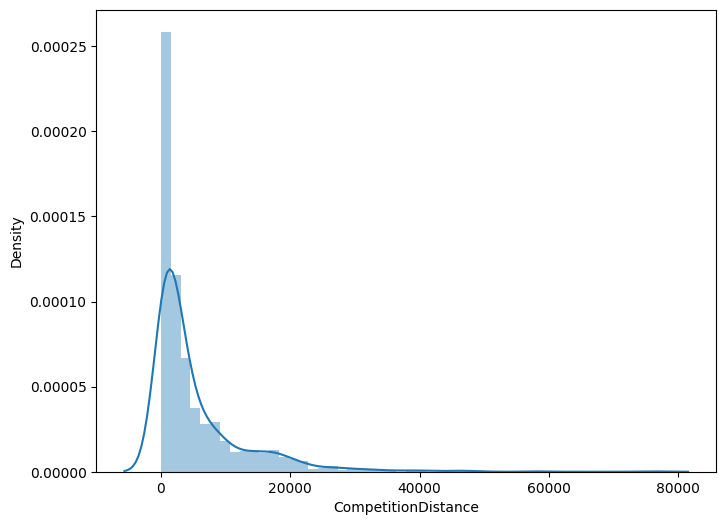

In [29]:
# create a density plot to show the distribution of values in CompetitionDistance

density_plot_of_a_feature(store_df, 'CompetitionDistance')

The distribution of CompetitionDistance is positively skewed. So it is safe to impute missing values with mode or median. Since the PDF of the peak of the distribution is very low, it is better to go with median instead of mode.

In [30]:
# filling the missing values with median
store_df["CompetitionDistance"].fillna(value = store_df.CompetitionDistance.median(), inplace=True)

Both CompetitionOpenSinceMonth and CompetitionOpenSinceYear have the same number of missing values. This may mean that both the features have missing values in the same rows.

In [31]:
# check if CompetitionOpenSinceMonth and CompetitionOpenSinceYear have missing values in the same rows

count = 0
for index, row in store_df.iterrows():
  if np.isnan(row["CompetitionOpenSinceMonth"]) and np.isnan(row["CompetitionOpenSinceYear"]):
    count += 1

print(count)

354


So, both the features have missing values in the same rows. Now lets check if its related to CompetitionDistance.

In [32]:
# show CompetitionDistance, CompetitionOpenSinceMonth and CompetitionOpenSinceYear for rows
# where CompetitionOpenSinceMonth and CompetitionOpenSinceYear have missing values

store_df[np.isnan(store_df["CompetitionOpenSinceMonth"])].loc[:, ["CompetitionDistance", "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"]]

CompetitionDistance  CompetitionOpenSinceMonth  \
Store                                                   
12                  1070.0                        NaN   
13                   310.0                        NaN   
16                  3270.0                        NaN   
19                  3240.0                        NaN   
22                  1040.0                        NaN   
...                    ...                        ...   
1096                1130.0                        NaN   
1100                 540.0                        NaN   
1113                9260.0                        NaN   
1114                 870.0                        NaN   
1115                5350.0                        NaN   

       CompetitionOpenSinceYear  
Store                            
12                          NaN  
13                          NaN  
16                          NaN  
19                          NaN  
22                          NaN  
...                         ...  
1096                        NaN  
1100                        NaN  
1113                        NaN  
1114                        NaN  
1115                        NaN  

[354 rows x 3 columns]

Since no useful information was obtained from the above process, lets impute missing values with the most frequent values.

In [33]:
# filling the missing values with mode
store_df["CompetitionOpenSinceMonth"].fillna(value = store_df.CompetitionOpenSinceMonth.mode()[0], inplace=True)
store_df["CompetitionOpenSinceYear"].fillna(value = store_df.CompetitionOpenSinceYear.mode()[0], inplace=True)

Promo2SinceWeek, Promo2SinceYear and PromoInterval have the same number of missing values. This may mean that these features have missing values in the same rows.

In [34]:
# check if Promo2SinceWeek, Promo2SinceYear and PromoInterval have missing values in the same rows

count = 0
for index, row in store_df.iterrows():
  if np.isnan(row["Promo2SinceWeek"]) and np.isnan(row["Promo2SinceYear"]) and np.isnan(row["PromoInterval"]):
    count += 1

print(count)

544


So, these features have missing values in the same rows. Now lets check if its related to Promo2.

In [35]:
# show Promo2, Promo2SinceWeek, Promo2SinceYear and PromoInterval for rows
# where Promo2SinceWeek, Promo2SinceYear and PromoInterval have missing values

store_df[np.isnan(store_df["Promo2SinceWeek"])].loc[:, ["Promo2", "Promo2SinceWeek", "Promo2SinceYear", "PromoInterval"]]

Promo2  Promo2SinceWeek  Promo2SinceYear PromoInterval
Store                                                        
1           0              NaN              NaN           NaN
4           0              NaN              NaN           NaN
5           0              NaN              NaN           NaN
6           0              NaN              NaN           NaN
7           0              NaN              NaN           NaN
...       ...              ...              ...           ...
1108        0              NaN              NaN           NaN
1110        0              NaN              NaN           NaN
1112        0              NaN              NaN           NaN
1113        0              NaN              NaN           NaN
1114        0              NaN              NaN           NaN

[544 rows x 4 columns]

Promo2 value of head and tail of the above dataframe is 0. Lets check whether missing values in Promo2SinceWeek, Promo2SinceYear and PromoInterval is due to 0 in Promo2.

In [36]:
# show the count of each unique value in Promo2
store_df["Promo2"].value_counts()

1    571
0    544
Name: Promo2, dtype: int64

So, missing values in Promo2SinceWeek, Promo2SinceYear and PromoInterval is due to 0 in Promo2. Lets impute missing values with 0.

In [37]:
# filling the missing values with value 0
store_df["Promo2SinceWeek"].fillna(value = 0, inplace=True)
store_df["Promo2SinceYear"].fillna(value = 0, inplace=True)
store_df["PromoInterval"].fillna(value = 0, inplace=True)

In [38]:
# number and percentage of missing values in the store data
get_missing_values_count_and_percentage(store_df)

No missing values in the dataframe


### Merging Dataframes

In [39]:
# merge the two datasets on Store data
rossmann_df = sales_df.merge(right=store_df, on="Store", how="left").reset_index()

In [40]:
# exploring the head of the resultant dataframe
rossmann_df.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         a          a                570.0   
2              1         a          a              14130.0   
3              1         c          c                620.0   
4              1         a          a              29910.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                       11.0                    2007.0       1   
2                       12.0                    2006.0       1   
3                        9.0                    2009.0       0   
4                        4.0                    2015.0       0   

   Promo2SinceWeek  Promo2SinceYear    PromoInterval  
0              0.0              0.0                0  
1             13.0           2010.0  Jan,Apr,Jul,Oct  
2             14.0           2011.0  Jan,Apr,Jul,Oct  
3              0.0              0.0                0  
4              0.0              0.0                0

### Conversion of Column Datatype

In [41]:
# datatypes of columns in merged dataframe
rossmann_df.dtypes

Store                          int64
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [42]:
# date should be converted from object to datetime
rossmann_df['Date'] = pd.to_datetime(rossmann_df['Date'])

In [43]:
# unique values in StateHoliday
rossmann_df["StateHoliday"].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [44]:
# convert StateHoliday values to int
rossmann_df["StateHoliday"].replace({'0':0, 'a':1, 'b':1, 'c':1}, inplace=True)
rossmann_df["StateHoliday"].unique()

array([0, 1], dtype=int64)

In [45]:
# convert CompetitionOpenSinceMonth, CompetitionOpenSinceYear, Promo2SinceWeek, Promo2SinceYear
# from float to int
rossmann_df = rossmann_df.astype({"CompetitionOpenSinceMonth":int, "CompetitionOpenSinceYear":int, "Promo2SinceWeek":int, "Promo2SinceYear":int})

In [46]:
# datatypes of columns in merged dataframe
rossmann_df.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                          int64
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth             int32
CompetitionOpenSinceYear              int32
Promo2                                int64
Promo2SinceWeek                       int32
Promo2SinceYear                       int32
PromoInterval                        object
dtype: object

### Manipulation of Columns

In [47]:
# split the date column into month and year
rossmann_df['WeekOfYear'] = rossmann_df['Date'].dt.week
rossmann_df['Month'] = rossmann_df['Date'].dt.month
rossmann_df['Year'] = rossmann_df['Date'].dt.year

# create a new feature which shows the number of months passed since competition started
rossmann_df['CompetitionOpenNumMonths'] = (rossmann_df['Year'] - rossmann_df['CompetitionOpenSinceYear']) * 12 + (rossmann_df['Month'] - rossmann_df['CompetitionOpenSinceMonth'])

# create a new feature which shows the number of weeks passed since promo 2 started
rossmann_df['Promo2NumWeeks'] = (rossmann_df['Year'] - rossmann_df['Promo2SinceYear']) * 52 + (rossmann_df['WeekOfYear'] - rossmann_df['Promo2SinceWeek'])

Lets check the CompetitionOpenNumMonths for any irregularities

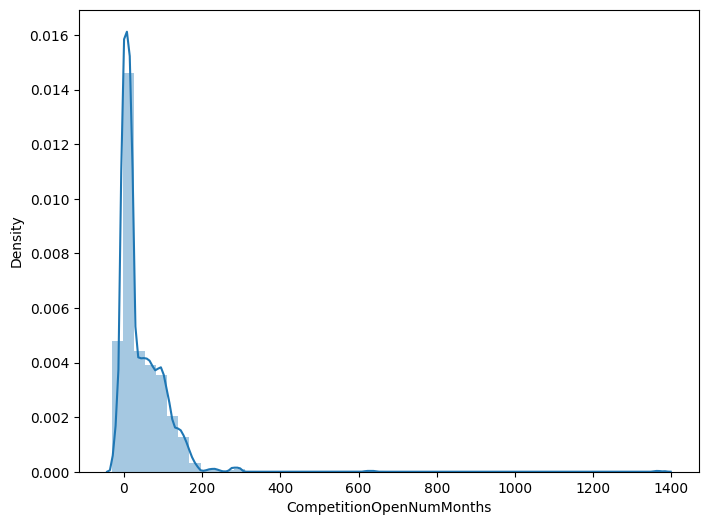

In [48]:
# check the distribution of CompetitionOpenNumMonths
density_plot_of_a_feature(rossmann_df, 'CompetitionOpenNumMonths')

Negative values for CompetitionOpenNumMonths are not acceptable. Lets check why negative values occured.

In [49]:
# dataset for negative CompetitionOpenNumMonths
rossmann_df[rossmann_df['CompetitionOpenNumMonths'] < 0].loc[:, ['WeekOfYear', 'Year', 'Promo2SinceWeek', 'Promo2SinceYear', 'Promo2NumWeeks']]

WeekOfYear  Year  Promo2SinceWeek  Promo2SinceYear  Promo2NumWeeks
687              31  2015               14             2011             225
1019             31  2015                0                0          104811
1071             31  2015                5             2010             286
1802             31  2015               14             2011             225
2134             31  2015                0                0          104811
...             ...   ...              ...              ...             ...
1017193           1  2013               14             2011              91
1017204           1  2013               31             2013             -30
1017206           1  2013                0                0          104677
1017207           1  2013                0                0          104677
1017208           1  2013               22             2012              31

[170688 rows x 5 columns]

Some values are negative because in some observations, the competition has not opened when the sales was recorded. Lets change all negative values to 0.

In [50]:
# change negative values of CompetitionOpenNumMonths to 0
rossmann_df['CompetitionOpenNumMonths'] = rossmann_df['CompetitionOpenNumMonths'].apply(lambda x: 0 if x < 0 else x)

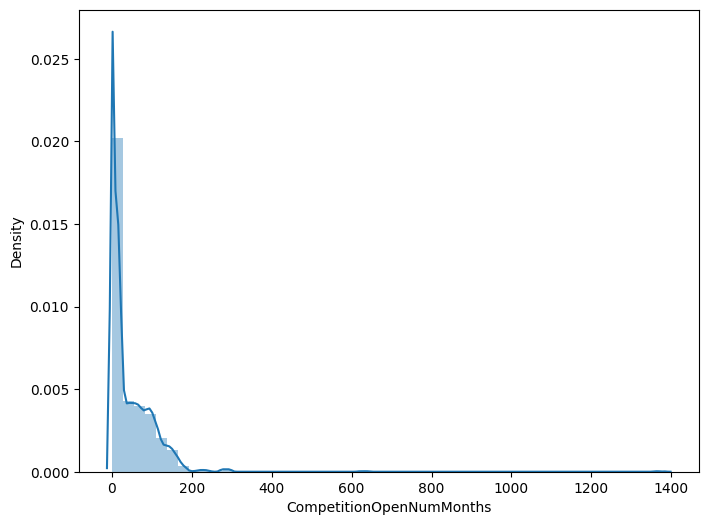

In [51]:
# check the distribution of CompetitionOpenNumMonths
density_plot_of_a_feature(rossmann_df, 'CompetitionOpenNumMonths')

Lets check the CompetitionOpenNumMonths for any irregularities.

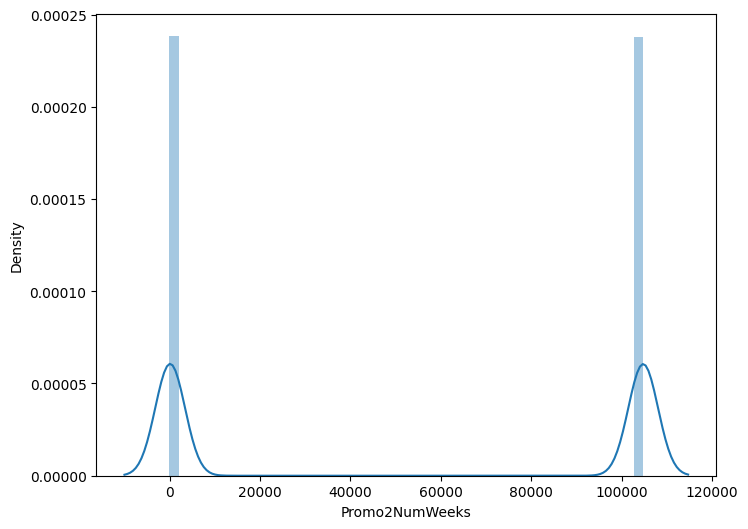

In [52]:
# check the distribution of Promo2NumWeeks
density_plot_of_a_feature(rossmann_df, 'Promo2NumWeeks')

Such large values of Promo2NumWeeks are not possible. Lets check why it occured.

In [53]:
# dataset for very large Promo2NumWeeks values
rossmann_df[rossmann_df['Promo2NumWeeks'] > 100000].loc[:, ['WeekOfYear', 'Year', 'Promo2SinceWeek', 'Promo2SinceYear', 'Promo2NumWeeks']]

WeekOfYear  Year  Promo2SinceWeek  Promo2SinceYear  Promo2NumWeeks
0                31  2015                0                0          104811
3                31  2015                0                0          104811
4                31  2015                0                0          104811
5                31  2015                0                0          104811
6                31  2015                0                0          104811
...             ...   ...              ...              ...             ...
1017201           1  2013                0                0          104677
1017203           1  2013                0                0          104677
1017205           1  2013                0                0          104677
1017206           1  2013                0                0          104677
1017207           1  2013                0                0          104677

[508031 rows x 5 columns]

Very large values of Promo2NumWeeks was observed because Promo2SinceYear and Promo2SinceWeek is 0 where Promo2 is 0. Lets change all those values to 0.

In [54]:
# change the value of Promo2NumWeeks to 0 where Promo2 is 0
rossmann_df.loc[rossmann_df['Promo2'] == 0, 'Promo2NumWeeks'] = 0

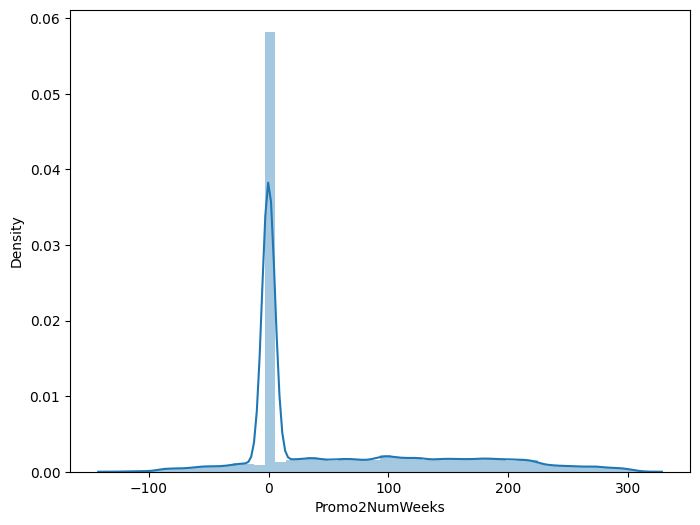

In [55]:
# check the distribution of Promo2NumWeeks
density_plot_of_a_feature(rossmann_df, 'Promo2NumWeeks')

Negative values for Promo2NumWeeks are not acceptable. Lets check why negative values occured.

In [56]:
# dataset for negative Promo2NumWeeks values
rossmann_df[rossmann_df['Promo2NumWeeks'] < 0].loc[:, ['WeekOfYear', 'Year', 'Promo2SinceWeek', 'Promo2SinceYear', 'Promo2NumWeeks']]

WeekOfYear  Year  Promo2SinceWeek  Promo2SinceYear  Promo2NumWeeks
68442            22  2015               23             2015              -1
68643            22  2015               23             2015              -1
68886            22  2015               23             2015              -1
69557            22  2015               23             2015              -1
69758            22  2015               23             2015              -1
...             ...   ...              ...              ...             ...
1017195           1  2013               40             2014             -91
1017196           1  2013                5             2013              -4
1017198           1  2013                5             2013              -4
1017199           1  2013               31             2013             -30
1017204           1  2013               31             2013             -30

[69970 rows x 5 columns]

Some values are negative because in some observations, the promo 2 has not started when the sales was recorded. Lets change all negative values to 0.

In [57]:
# change negative values of Promo2NumWeeks to 0
rossmann_df['Promo2NumWeeks'] = rossmann_df['Promo2NumWeeks'].apply(lambda x: 0 if x < 0 else x)

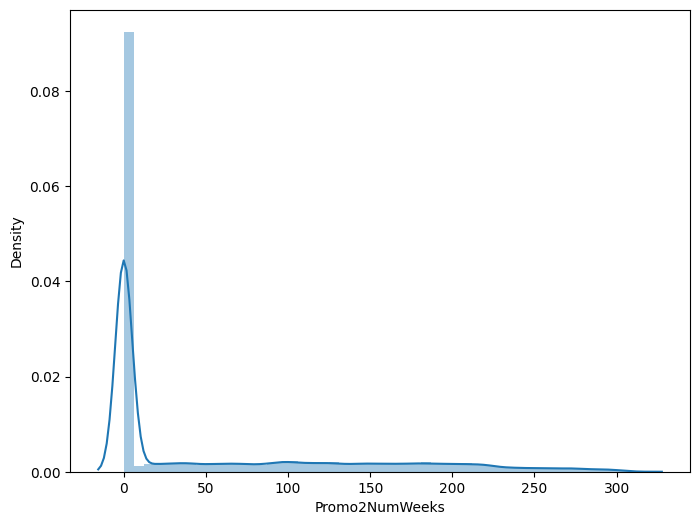

In [58]:
# check the distribution of Promo2NumWeeks
density_plot_of_a_feature(rossmann_df, 'Promo2NumWeeks')

In [59]:
# exploring the head of the resultant dataframe
rossmann_df.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1             0   
1      2          5 2015-07-31   6064        625     1      1             0   
2      3          5 2015-07-31   8314        821     1      1             0   
3      4          5 2015-07-31  13995       1498     1      1             0   
4      5          5 2015-07-31   4822        559     1      1             0   

   SchoolHoliday StoreType  ... CompetitionOpenSinceYear  Promo2  \
0              1         c  ...                     2008       0   
1              1         a  ...                     2007       1   
2              1         a  ...                     2006       1   
3              1         c  ...                     2009       0   
4              1         a  ...                     2015       0   

   Promo2SinceWeek  Promo2SinceYear    PromoInterval  WeekOfYear  Month  Year  \
0                0                0                0          31      7  2015   
1               13             2010  Jan,Apr,Jul,Oct          31      7  2015   
2               14             2011  Jan,Apr,Jul,Oct          31      7  2015   
3                0                0                0          31      7  2015   
4                0                0                0          31      7  2015   

   CompetitionOpenNumMonths  Promo2NumWeeks  
0                        82               0  
1                        92             278  
2                       103             225  
3                        70               0  
4                         3               0  

[5 rows x 23 columns]

In [60]:
# exporting clean data
rossmann_df.to_csv('../data/clean_sales_data.csv')

# Exploratory Data Analysis

Lets check out the distribution of all the features.

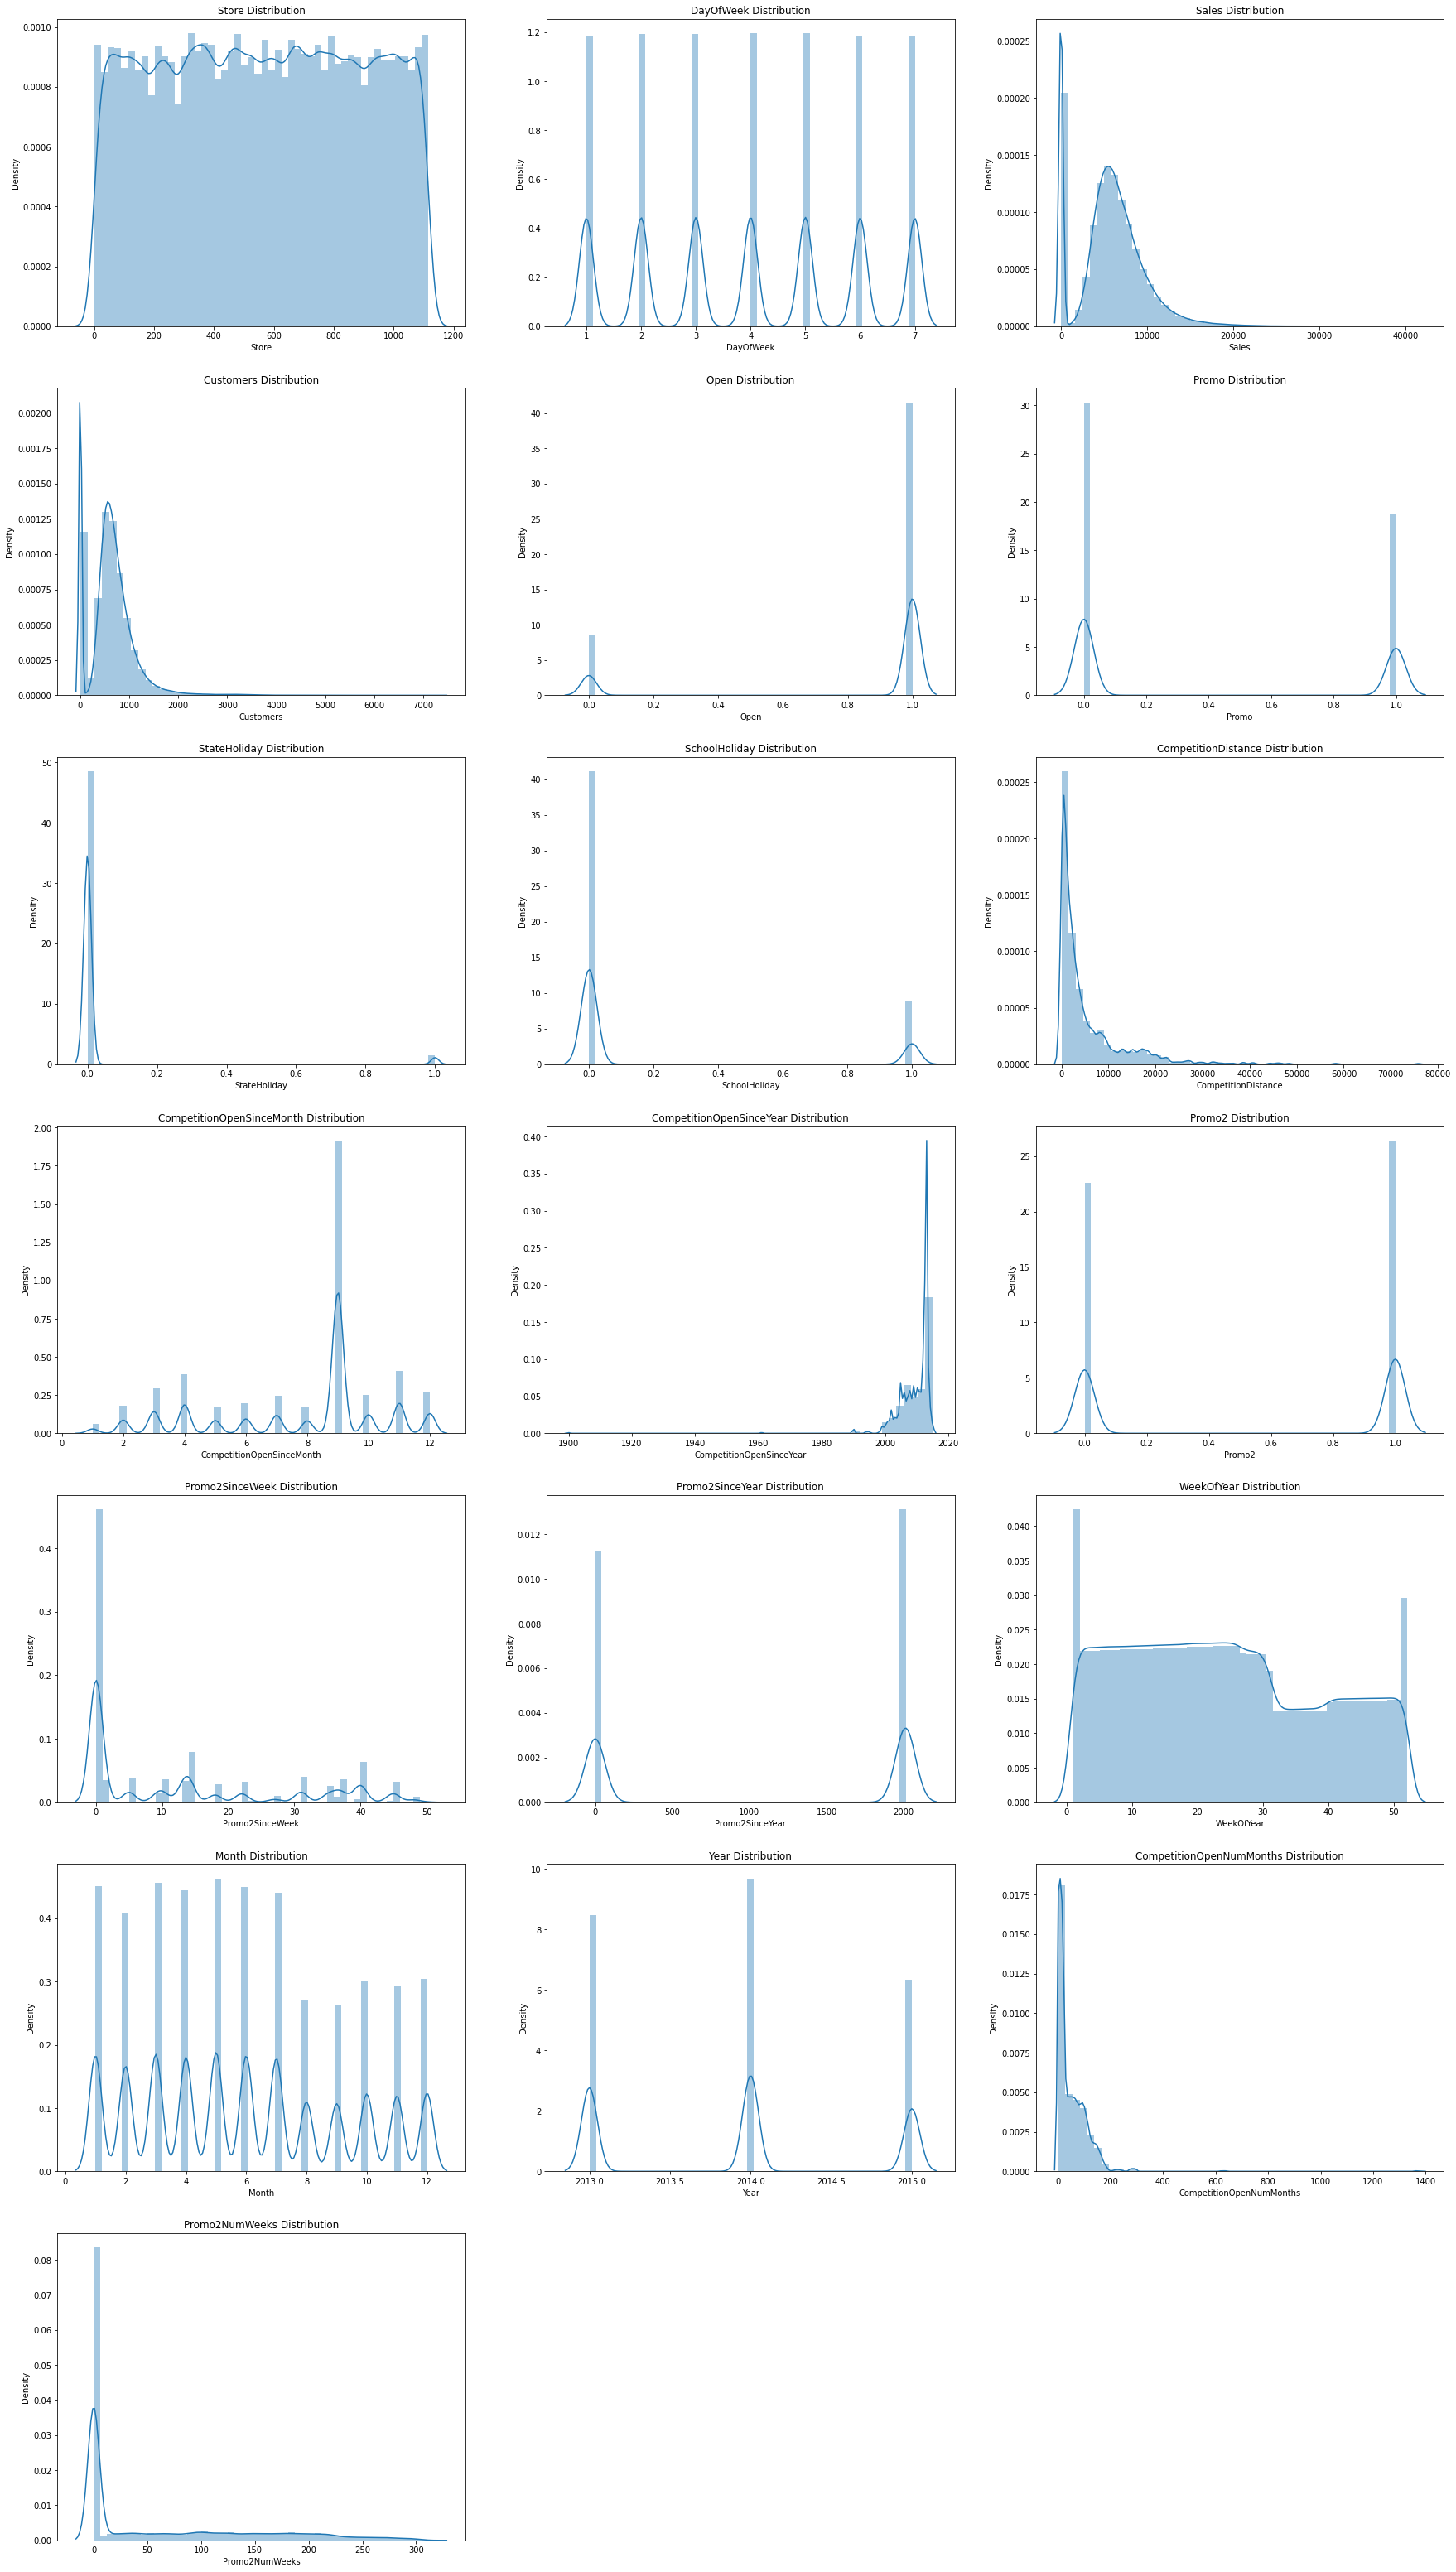

In [ ]:
density_plot_of_all_features(rossmann_df[(rossmann_df['CompetitionOpenNumMonths'] != 0) | (rossmann_df['Promo2NumWeeks'] != 0)])

Distribution of sales, customer, competition distance, competition open number of months and promo 2 number of weeks are positively skewed. Everything else are categorial features.

Lets check the variation in sales with the numerical features.

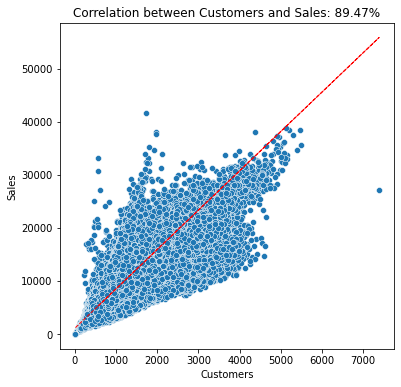

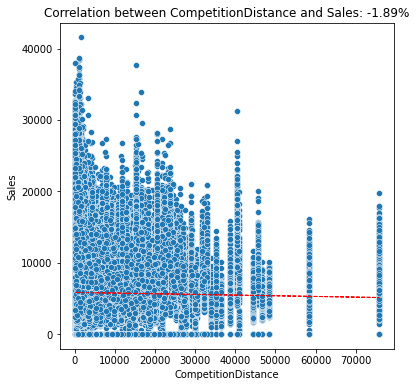

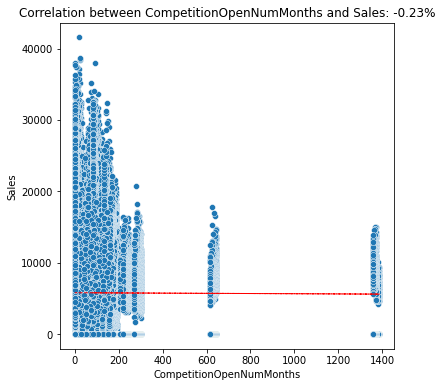

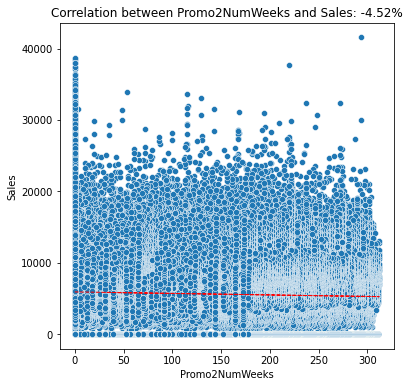

In [ ]:
# generate scatter plot to show the variation in sales with the numerical features
numerical_features = ['Customers', 'CompetitionDistance', 'CompetitionOpenNumMonths', 'Promo2NumWeeks']

for feature in numerical_features:
  scatter_plot_with_regression_line(rossmann_df, feature, 'Sales')

*   Relationship between sales and customers is almost linear. So we can safely say that as the number of customers increases, sales also increase. 
*   Sales decreases with increase in competition distance, competition open number of months and promo 2 number of weeks but they have very low correlation with competition distance.

Lets check how some categorical features like DayOfWeek, Promo, SchoolHoliday, etc. affect the sales and customers.

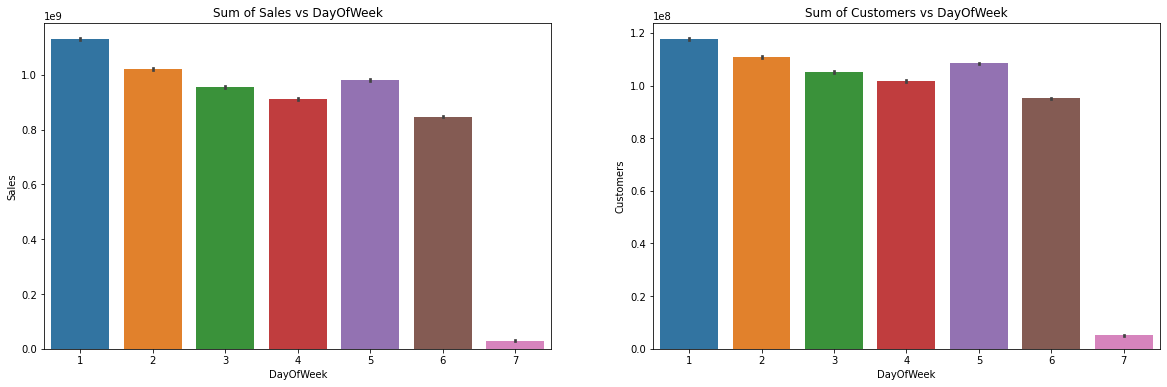

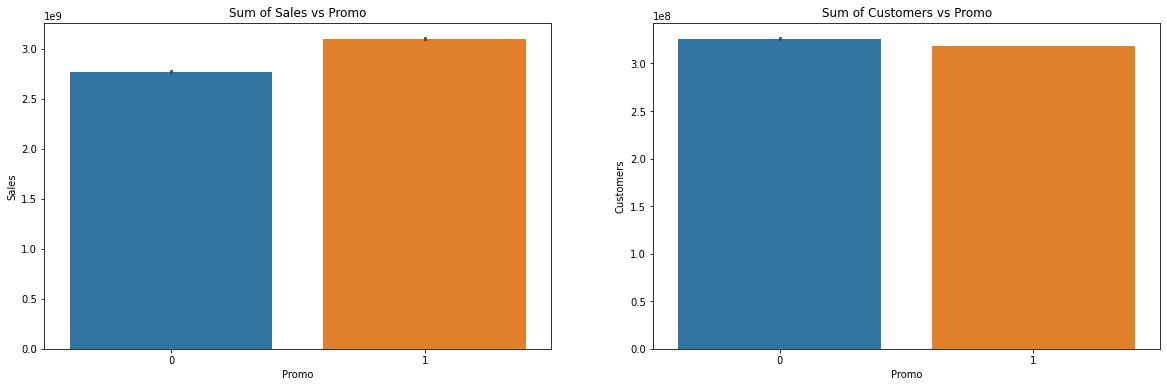

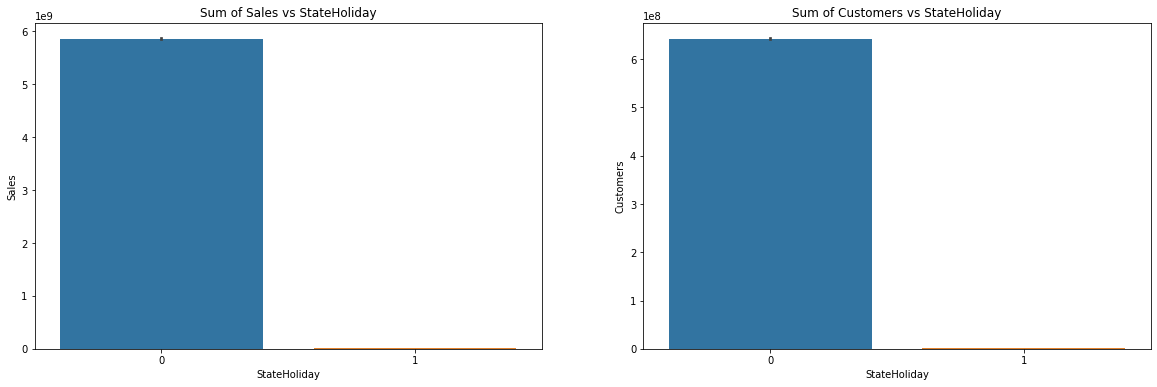

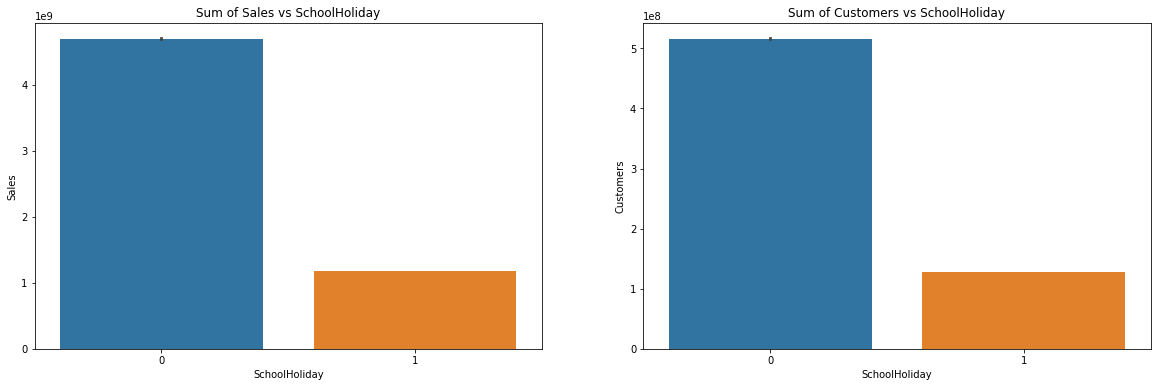

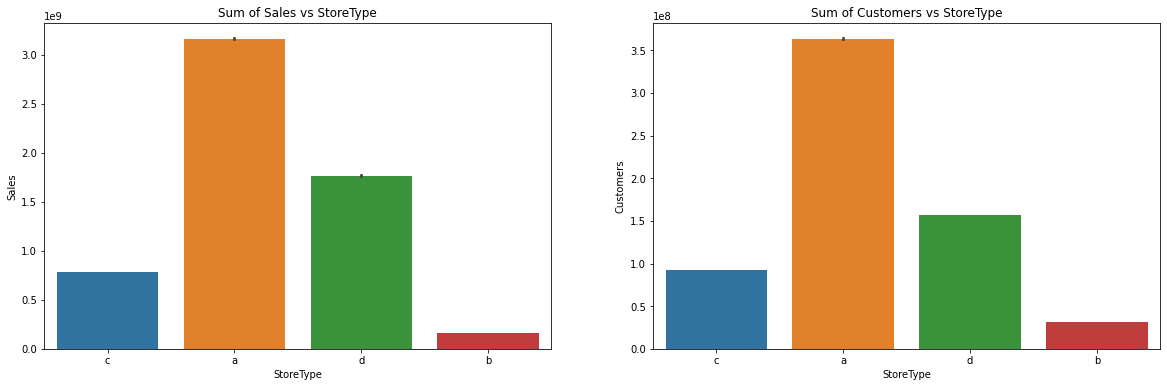

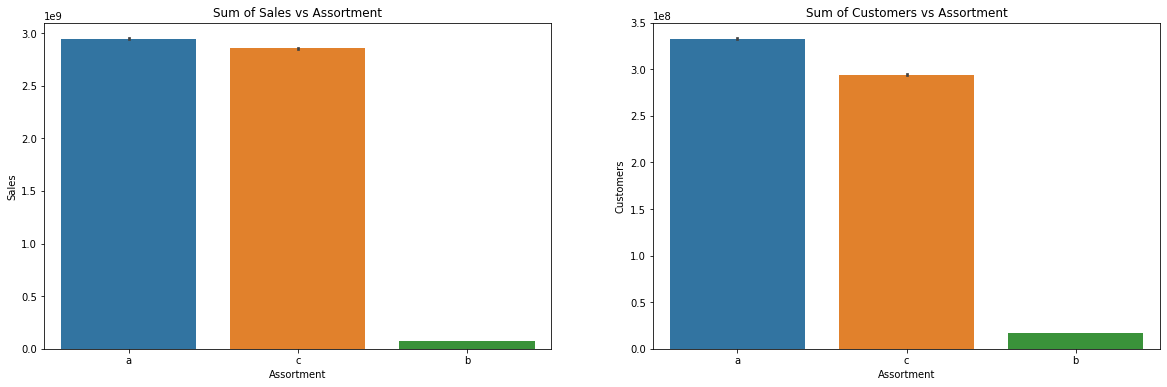

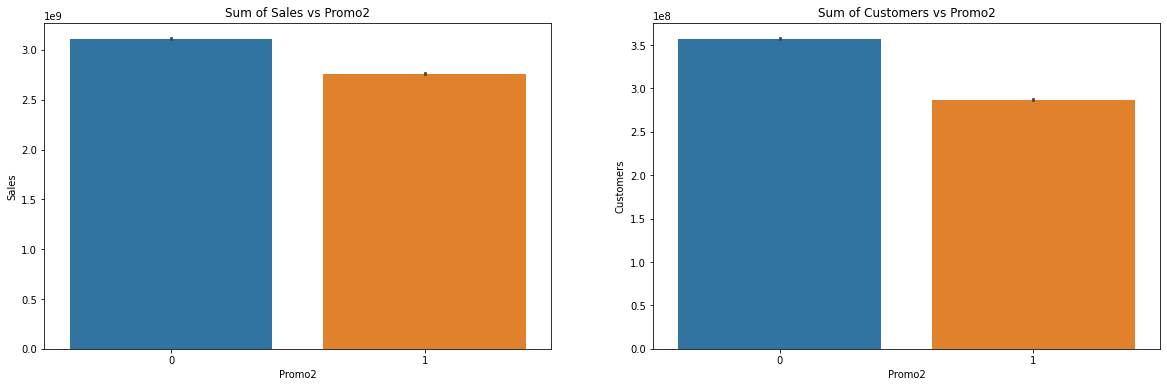

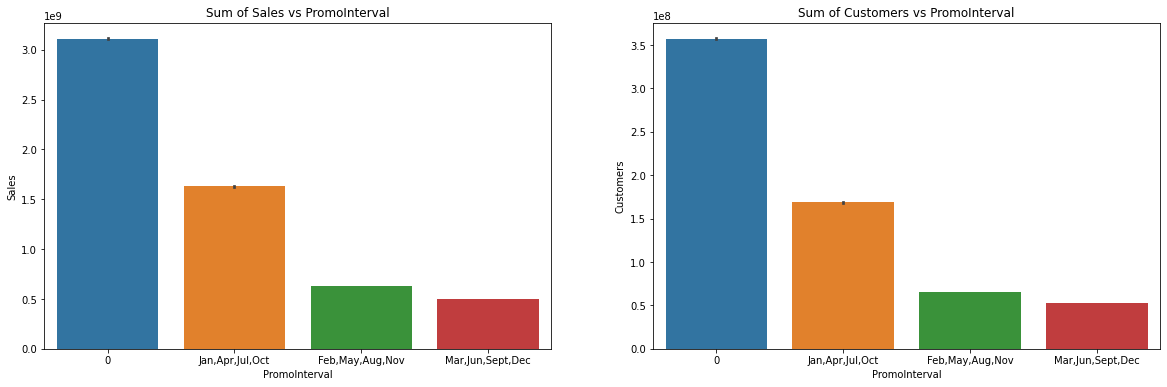

In [ ]:
# categotical variables under consideration
categorical_variables = ['DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                         'StoreType', 'Assortment', 'Promo2', 'PromoInterval']

# plot bar graphs for each categorical variable against the sum of sales
for feature in categorical_variables:
  plot_bar_graph_with_two_features(rossmann_df, feature, ['Sales', 'Customers'])

The following observations were made from the above graphs:
*   Highest sales are recorded on Mondays and lowest sales are recorded on Sundays. This may be because most of the shops are closed on Sundays and this leads to higher demand on the next day, which is Monday.
*   Presence of promos increases sales.
*   Shops are closed on all state holidays but sometimes some shops are opened during school holidays, which may be Saturdays.
*   Sales are higher on school holidays than other days.
*   Store type a records the most amount of sales mostly because the majority of the shops are type a.
*   Sales of assortment b is very rare.
*   Participants of promo 2 has less sales might be because it is seasonal and doesn't have any effect on sales.
*   Promo interval Jan, Apr, Jul, Oct brings in more sales.









Lets check which store type and assortment has the highest average sales and customer.

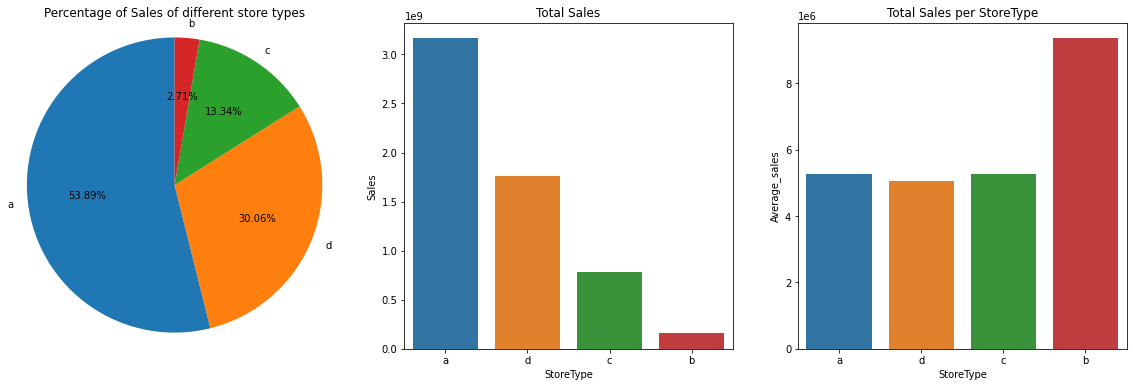

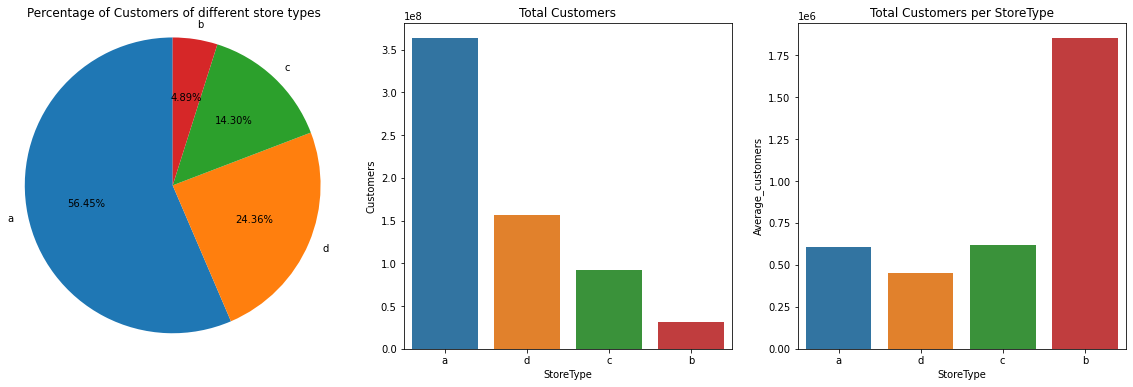

In [ ]:
# get a dataframe with count, sales, average sales, percentage sales, customers, average customers and percentage of customers of different store types
store_type_count_df = get_count_from_column(rossmann_df.copy().loc[0:1115, ['Store', 'StoreType']], 'StoreType').rename(columns={'index':'StoreType'})

store_type_sales_sum_df = get_sum_from_column(rossmann_df, 'StoreType', 'Sales')
store_type_df = store_type_count_df.merge(right=store_type_sales_sum_df, on='StoreType')
store_type_df['Percent_sales'] = round(store_type_df['Sales']/store_type_df['Sales'].sum()*100, 2)
store_type_df['Average_sales'] = round(store_type_df['Sales']/store_type_df['count'], 2)

store_type_customer_sum_df = get_sum_from_column(rossmann_df, 'StoreType', 'Customers')
store_type_df = store_type_df.merge(right=store_type_customer_sum_df, on='StoreType')
store_type_df['Percent_customers'] = round(store_type_df['Customers']/store_type_df['Customers'].sum()*100, 2)
store_type_df['Average_customers'] = round(store_type_df['Customers']/store_type_df['count'], 2)

for feature in ('Sales', 'Customers'):
  fig, axes = plt.subplots(1, 3, figsize=(20, 6))
  axes[0].pie(store_type_df.loc[:, feature], labels=store_type_df.loc[:, 'StoreType'], autopct='%1.2f%%', startangle=90)
  axes[0].axis('equal')
  axes[0].set_title(f"Percentage of {feature} of different store types")

  sns.barplot(ax=axes[1], x=store_type_df['StoreType'], y=store_type_df[feature])
  axes[1].set_title(f"Total {feature}")

  sns.barplot(ax=axes[2], x=store_type_df['StoreType'], y=store_type_df['Average_' + feature.lower()])
  axes[2].set_title(f"Total {feature} per StoreType")

  plt.show()

Even though the volume of sales and customers is low, store type b has the highest average sales and customers. This means store type b is more preferred by customers.

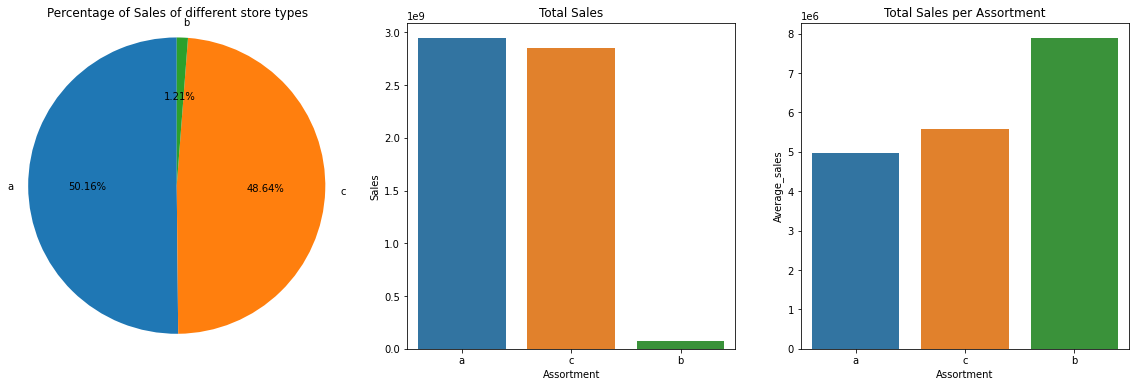

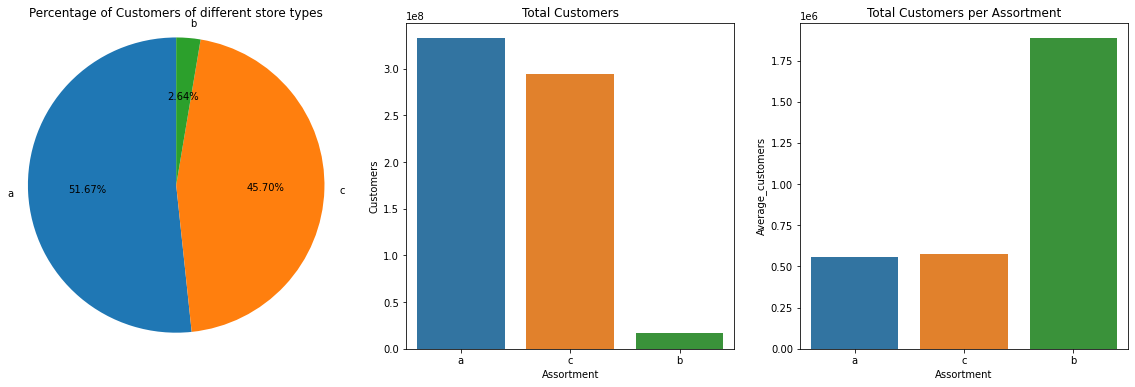

In [ ]:
# get a dataframe with count, sales, average sales, percentage sales, customers, average customers and percentage of customers of different assortments
assortment_count_df = get_count_from_column(rossmann_df.copy().loc[0:1115, ['Store', 'Assortment']], 'Assortment').rename(columns={'index':'Assortment'})

assortment_sales_sum_df = get_sum_from_column(rossmann_df, 'Assortment', 'Sales')
assortment_df = assortment_count_df.merge(right=assortment_sales_sum_df, on='Assortment')
assortment_df['Percent_sales'] = round(assortment_df['Sales']/assortment_df['Sales'].sum()*100, 2)
assortment_df['Average_sales'] = round(assortment_df['Sales']/assortment_df['count'], 2)

assortment_customer_sum_df = get_sum_from_column(rossmann_df, 'Assortment', 'Customers')
assortment_df = assortment_df.merge(right=assortment_customer_sum_df, on='Assortment')
assortment_df['Percent_customers'] = round(assortment_df['Customers']/assortment_df['Customers'].sum()*100, 2)
assortment_df['Average_customers'] = round(assortment_df['Customers']/assortment_df['count'], 2)

for feature in ('Sales', 'Customers'):
  fig, axes = plt.subplots(1, 3, figsize=(20, 6))
  axes[0].pie(assortment_df.loc[:, feature], labels=assortment_df.loc[:, 'Assortment'], autopct='%1.2f%%', startangle=90)
  axes[0].axis('equal')
  axes[0].set_title(f"Percentage of {feature} of different store types")

  sns.barplot(ax=axes[1], x=assortment_df['Assortment'], y=assortment_df[feature])
  axes[1].set_title(f"Total {feature}")

  sns.barplot(ax=axes[2], x=assortment_df['Assortment'], y=assortment_df['Average_' + feature.lower()])
  axes[2].set_title(f"Total {feature} per Assortment")

  plt.show()

Even though the volume of sales and customers is low, assortment b has the highest average sales and customers. This means assortment b is in high demand.

Lets check the number of sales for each assortment in different store types.

Text(0.5, 1.0, 'Number of Sales for each Assortment per Store Type')

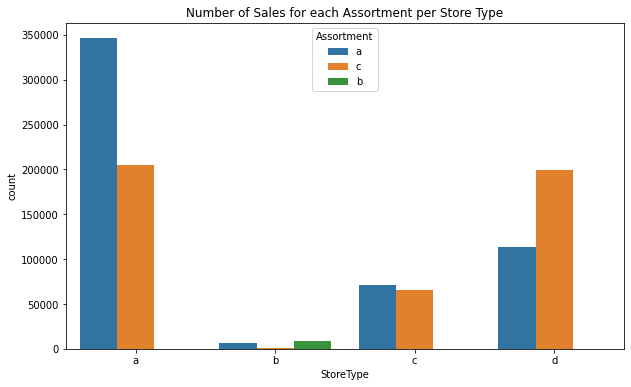

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='StoreType', hue='Assortment', order=sorted(rossmann_df['StoreType'].unique().tolist()), data=rossmann_df, palette=sns.color_palette(n_colors=3))
plt.title("Number of Sales for each Assortment per Store Type")

*   Only store type b sells assortment b and it has higher sales than assortment a.

Lets check how continous features like month, year, week, etc. affects the sales and customers.

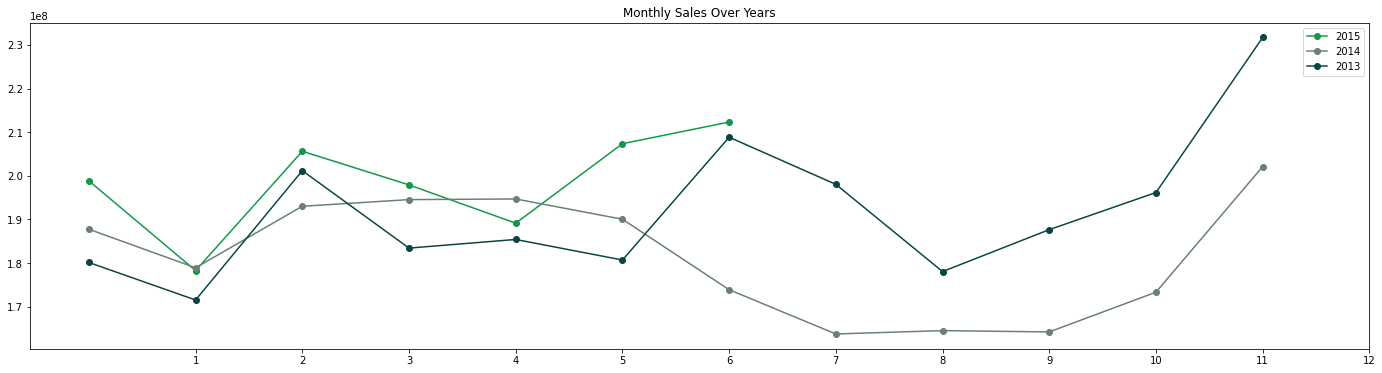

In [ ]:
# line graph of monthly sales over years
plot_line_graph_with_two_features_over_time(rossmann_df, 'Month', 'Sales', 'Year', 'Monthly')

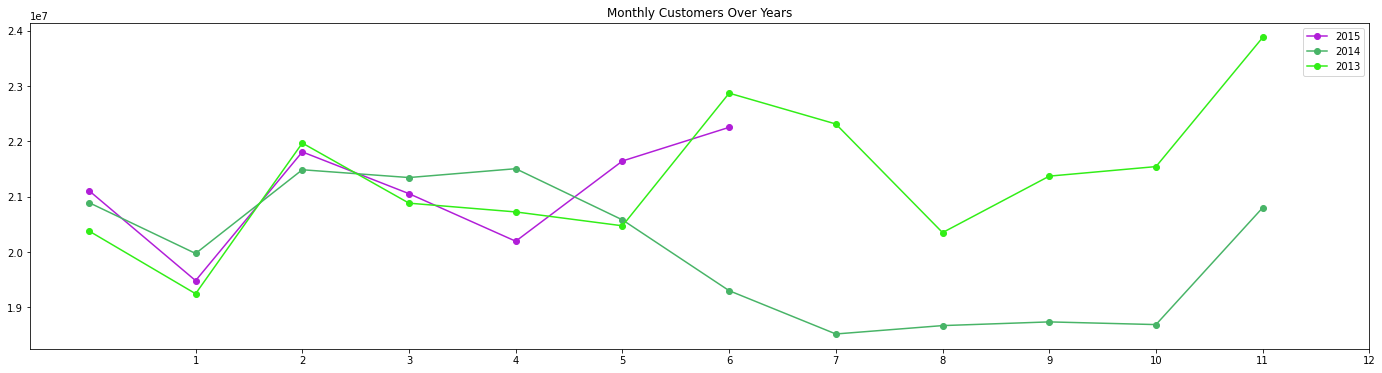

In [ ]:
# line graph of monthly customers over years
plot_line_graph_with_two_features_over_time(rossmann_df, 'Month', 'Customers', 'Year', 'Monthly')

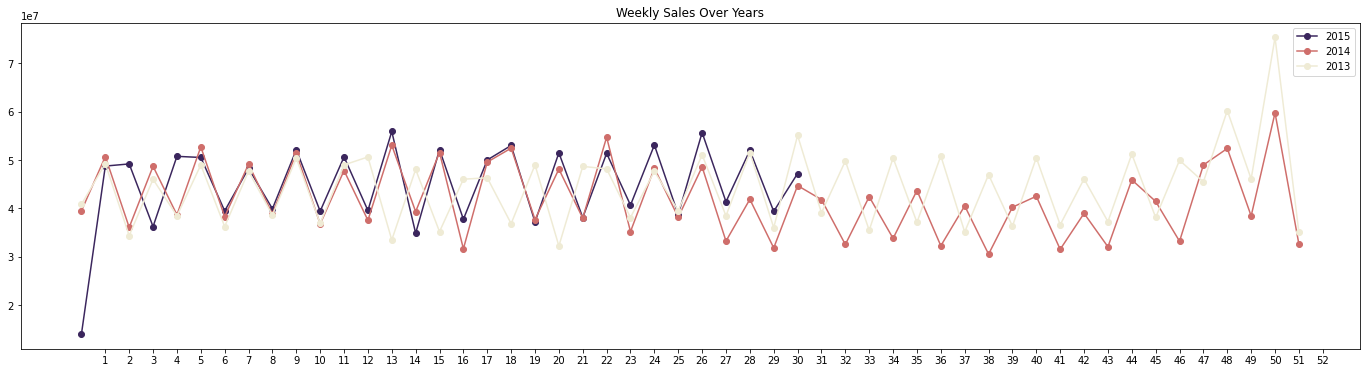

In [ ]:
# line graph of weekly sales over years
plot_line_graph_with_two_features_over_time(rossmann_df, 'WeekOfYear', 'Sales', 'Year', 'Weekly')

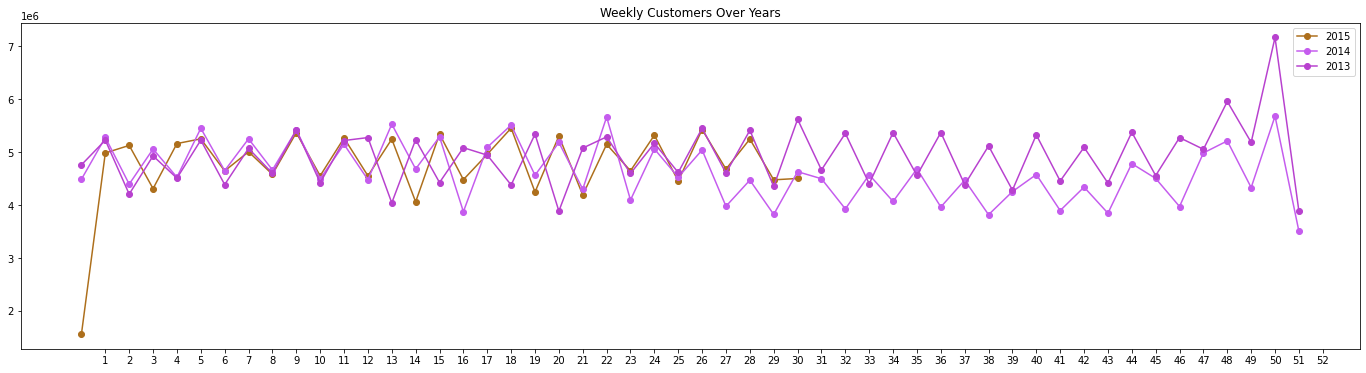

In [ ]:
# line graph of weekly customers over years
plot_line_graph_with_two_features_over_time(rossmann_df, 'WeekOfYear', 'Customers', 'Year', 'Weekly')

Weekly Sales and Customers are showing almost similar trends for all years. Both peaks at mid-December.

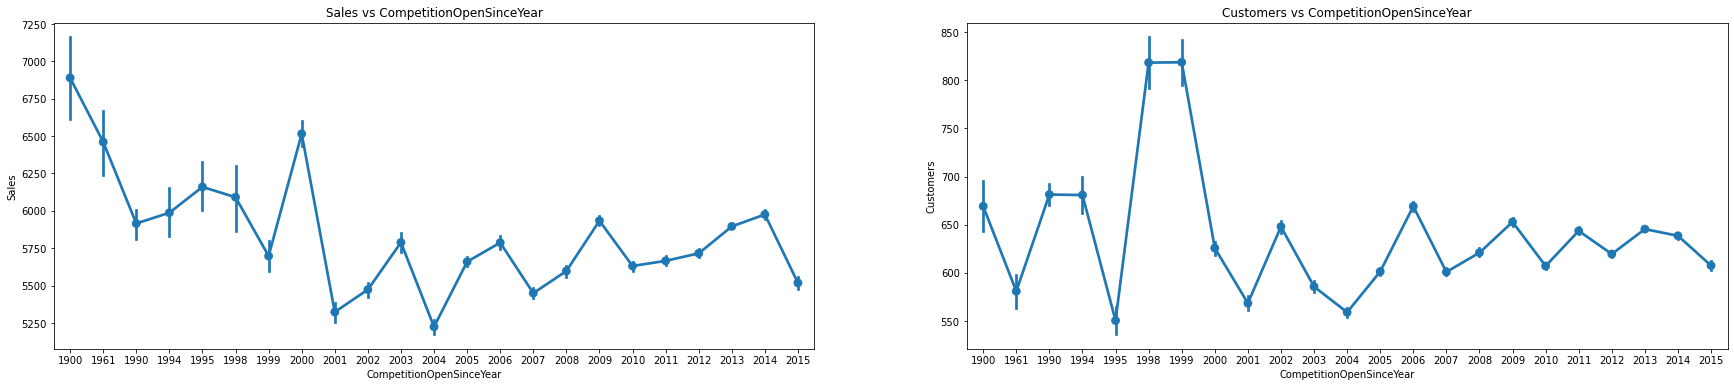

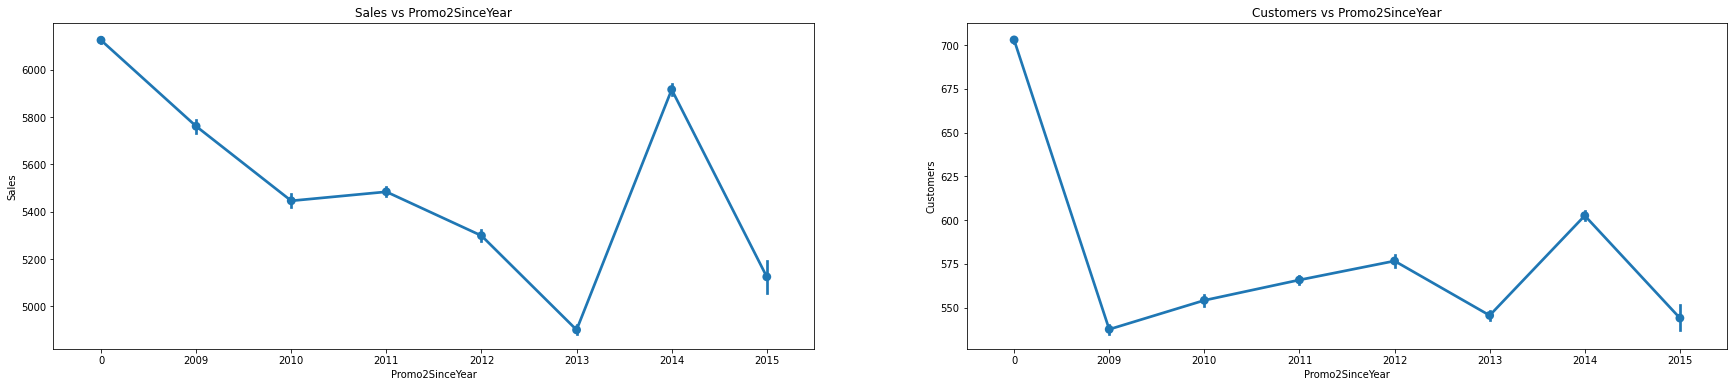

In [ ]:
# plot point plot for CompetitionOpenSinceYear & Promo2SinceYear
for feature in ('CompetitionOpenSinceYear', 'Promo2SinceYear'):
  fig, axes = plt.subplots(1, 2, figsize=(30,6))

  # plot point plot for Sales
  sns.pointplot(ax=axes[0], x=feature, y='Sales', data=rossmann_df)
  axes[0].set_title(f'Sales vs {feature}')

  # plot point plot for Customers
  sns.pointplot(ax=axes[1], x=feature, y='Customers', data=rossmann_df)
  axes[1].set_title(f'Customers vs {feature}')

Sales peaked at 1900 when a few stores were present so there was only a little competition. As years passed sales started to decline due to the increase in competition. But number of customers has peaked during late 1990s. Sales due to promo 2 is generally decreasing over the years, only exception in 2014.

Lets visualize the relationship between various features using correlation heat map.

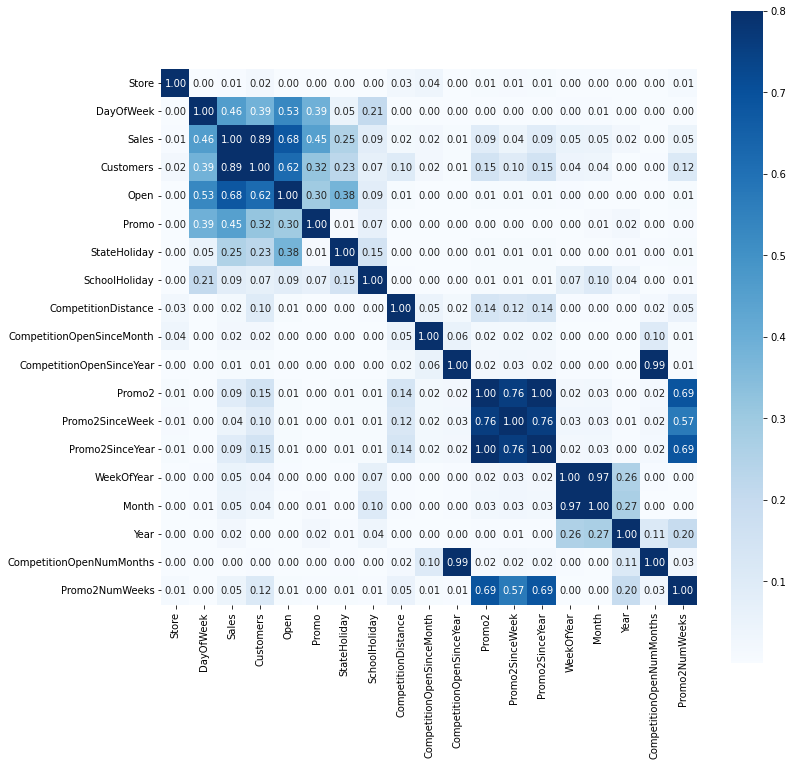

In [ ]:
# generate a correlation matrix using all features in the dataframe
corr_mat = rossmann_df.corr().abs()

# plot heatmap using correlation matrix
fig, axes = plt.subplots(figsize=(12, 12))
sns.heatmap(corr_mat, annot = True, fmt='.2f', annot_kws={'size': 10},  vmax=.8, square=True, cmap='Blues');

*   Customers and sales are also highly correlated because an increase in customers means that there must be an increase in sales too.
*   We can see that week of year and month are highly correlated, which is obvious since they represent points in the same timeframe but with different range.
*   Open is moderately correlated with sales and customers because customers, who drive sales, can access shops only when the shops are open.
*   Promo2 is correlated with promo2 since week and promo2 since year because promo2 is a binary feature and promo2 since week and promo2 since year have the value of 1 only when promo2 is 1.
*   Competition open number of months is highly correlated with competition open since year because it is derived from the latter.
*   Promo2 number of weeks is moderately correlated with Promo2, Promo2 since week and Promo2 since year as it is derived from these features.

# Feature Engineering

In [123]:
# exploring the head of the resultant dataframe
rossmann_df.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1             0   
1      2          5 2015-07-31   6064        625     1      1             0   
2      3          5 2015-07-31   8314        821     1      1             0   
3      4          5 2015-07-31  13995       1498     1      1             0   
4      5          5 2015-07-31   4822        559     1      1             0   

   SchoolHoliday StoreType  ... CompetitionOpenSinceYear  Promo2  \
0              1         c  ...                     2008       0   
1              1         a  ...                     2007       1   
2              1         a  ...                     2006       1   
3              1         c  ...                     2009       0   
4              1         a  ...                     2015       0   

   Promo2SinceWeek  Promo2SinceYear    PromoInterval  WeekOfYear  Month  Year  \
0                0                0                0          31      7  2015   
1               13             2010  Jan,Apr,Jul,Oct          31      7  2015   
2               14             2011  Jan,Apr,Jul,Oct          31      7  2015   
3                0                0                0          31      7  2015   
4                0                0                0          31      7  2015   

   CompetitionOpenNumMonths  Promo2NumWeeks  
0                        82               0  
1                        92             278  
2                       103             225  
3                        70               0  
4                         3               0  

[5 rows x 23 columns]

## Feature Selection

Lets remove store since we need sales of all stores, not a particular one and also sales can be predicted through store type, assortment, etc.

In [124]:
# drop Store
rossmann_df.drop('Store', axis=1, inplace=True)

Lets remove date since there are already day of week and week of year features in the dataset.

In [125]:
# drop Date
rossmann_df.drop('Date', axis=1, inplace=True)

Lets remove competition open since month and competition open since year as the information provided by them can be obtained from competition open number of months.

In [126]:
# drop CompetitionOpenSinceMonth & CompetitionOpenSinceYear
rossmann_df.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear'], axis=1, inplace=True)

Lets remove promo 2, promo 2 since week and promo 2 since year as the information provided by them can be obtained from promo 2 number of weeks.

In [127]:
# drop Promo2, Promo2SinceWeek & Promo2SinceYear
rossmann_df.drop(['Promo2', 'Promo2SinceWeek', 'Promo2SinceYear'], axis=1, inplace=True)

Lets remove month since we get the same information from week of the year.

In [128]:
# drop Month
rossmann_df.drop('Month', axis=1, inplace=True)

Lets remove year as we have already established in EDA that its not the year that influence the sales but the day of the week and the week of the year.

In [129]:
# drop Year
rossmann_df.drop('Year', axis=1, inplace=True)

In [130]:
# exploring the head of the resultant dataframe
rossmann_df.head()

DayOfWeek  Sales  Customers  Open  Promo  StateHoliday  SchoolHoliday  \
0          5   5263        555     1      1             0              1   
1          5   6064        625     1      1             0              1   
2          5   8314        821     1      1             0              1   
3          5  13995       1498     1      1             0              1   
4          5   4822        559     1      1             0              1   

  StoreType Assortment  CompetitionDistance    PromoInterval  WeekOfYear  \
0         c          a               1270.0                0          31   
1         a          a                570.0  Jan,Apr,Jul,Oct          31   
2         a          a              14130.0  Jan,Apr,Jul,Oct          31   
3         c          c                620.0                0          31   
4         a          a              29910.0                0          31   

   CompetitionOpenNumMonths  Promo2NumWeeks  
0                        82               0  
1                        92             278  
2                       103             225  
3                        70               0  
4                         3               0

## Handling Multicollinearity

Lets find out the VIF of all numerical features except 'Sales' in order to remove highly correlated features. Features having VIF greater than 5 should be eliminated.

In [131]:
# calculate VIF of all independant numerical features
numerical_independant_features = ['Customers', 'CompetitionDistance', 'CompetitionOpenNumMonths', 'Promo2NumWeeks']
calculate_vif_of_all_features(rossmann_df[[column for column in rossmann_df.describe().columns if column in numerical_independant_features]])

Feature       VIF
0                 Customers  1.500979
1       CompetitionDistance  1.256193
2  CompetitionOpenNumMonths  1.341305
3            Promo2NumWeeks  1.258342

All features have VIF less than 5.

## Handling Outliers

### Sales & Customers

Outlier detection for sales and customers can be done together since we have already established they have almost linear relationship. This way, detection and removal of outliers will be more convenient and accurate.

**Store Type**

Each store type records sales in different range. So it is more appropriate to detect outliers separately for each store type.

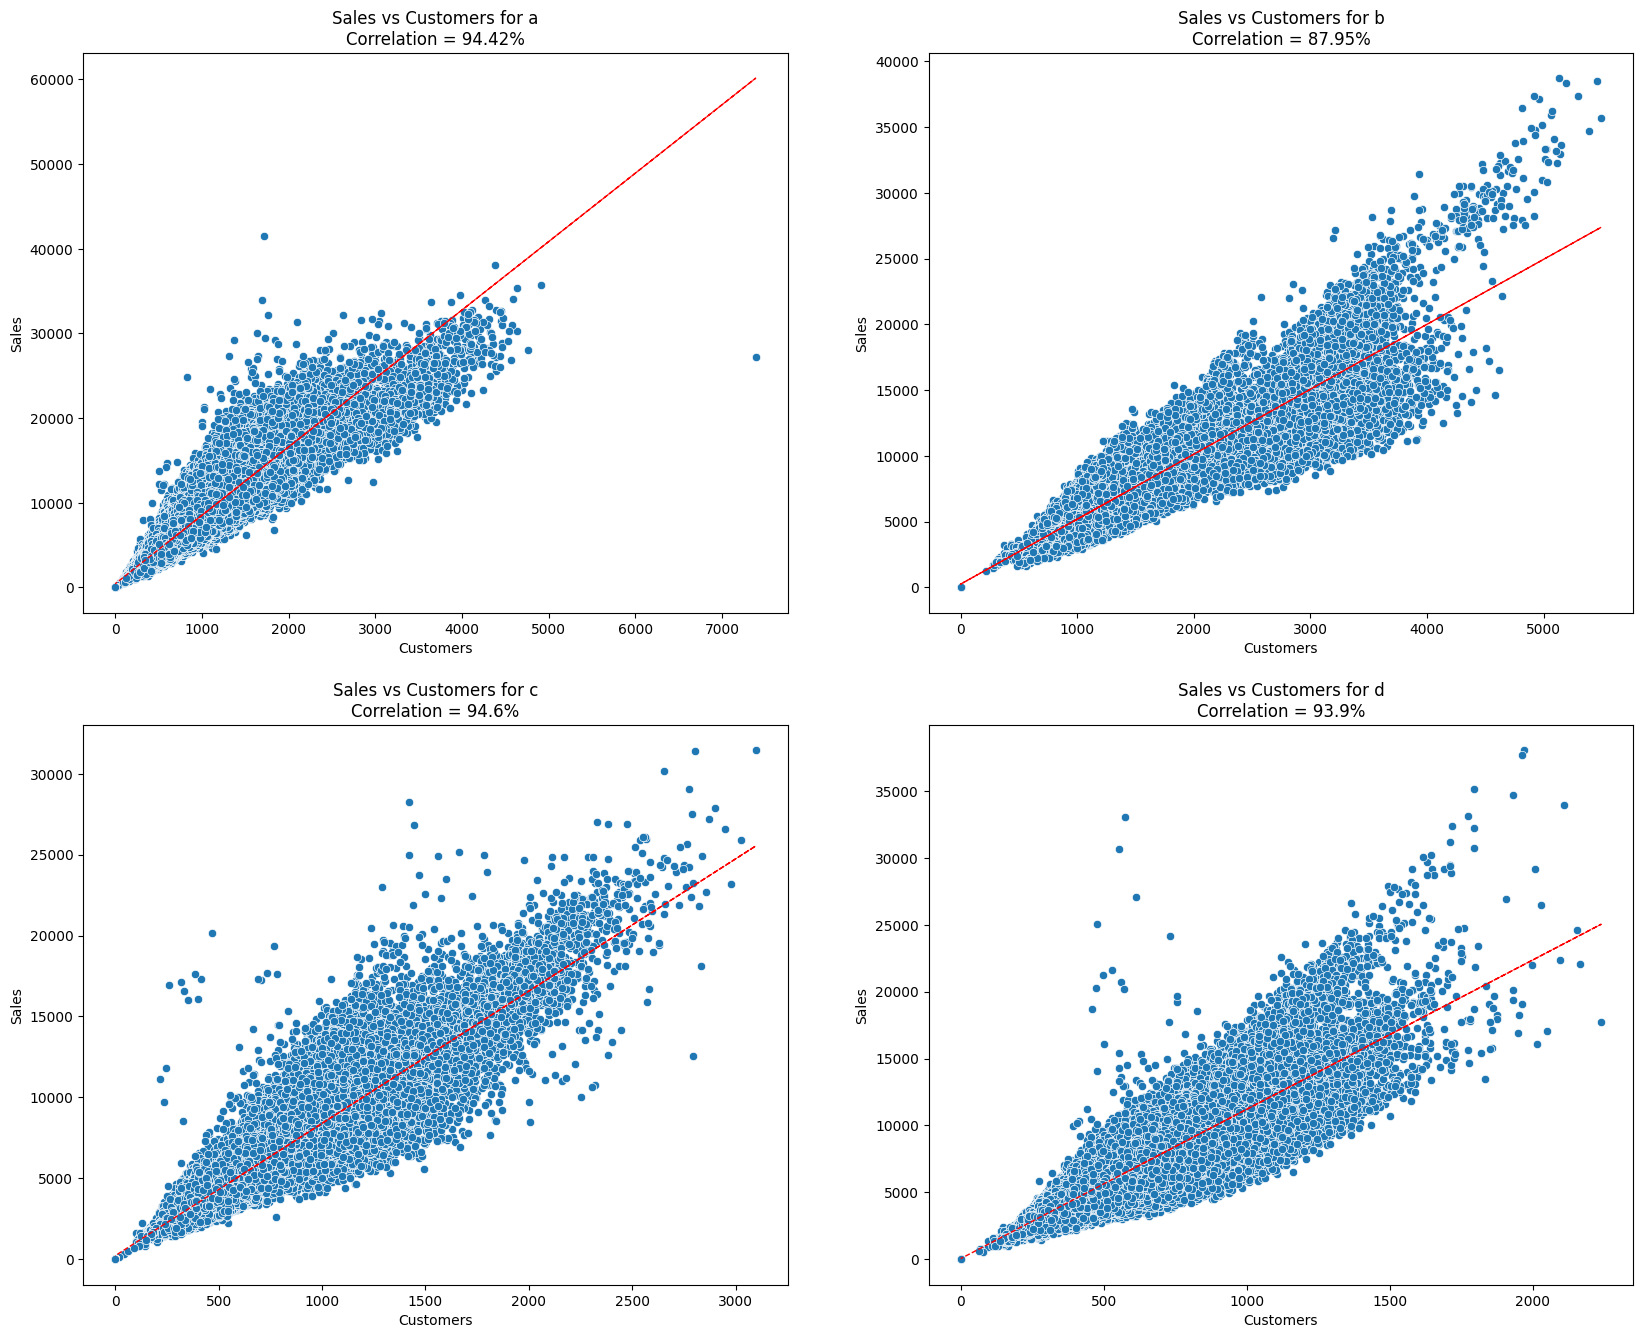

In [132]:
# generate scatter plots to check the linearity between sales and customers for each store type
scatter_plot_bw_sales_customers_with_feature_unique_values(rossmann_df, 'StoreType')

Outliers have been identified from the scatter plot. Now lets remove them.

In [133]:
# remove outliers with respect to store types
a_filter = rossmann_df[(rossmann_df['StoreType'] == 'a') & (((rossmann_df['Sales'] > 20000) & (rossmann_df['Customers'] < 1000)) | 
                                                            (rossmann_df['Sales'] > 40000) | (rossmann_df['Customers'] > 7000))].index
c_filter = rossmann_df[(rossmann_df['StoreType'] == 'c') & (((rossmann_df['Sales'] > 9000) & (rossmann_df['Customers'] < 500)) |
                                                            ((rossmann_df['Sales'] < 15000) & (rossmann_df['Customers'] > 2500)) |
                                                            ((rossmann_df['Sales'] > 25000) & (rossmann_df['Customers'] < 2000)) |
                                                             (rossmann_df['Sales'] > 30000))].index
d_filter = rossmann_df[(rossmann_df['StoreType'] == 'd') & ((rossmann_df['Sales'] > 17500) & (rossmann_df['Customers'] < 875) |
                                                            (rossmann_df['Sales'] > 31000) | (rossmann_df['Customers'] > 2000))].index

rossmann_df.drop(a_filter, inplace=True)
rossmann_df.drop(c_filter, inplace=True)
rossmann_df.drop(d_filter, inplace=True)

Now lets check if the outliers are removed

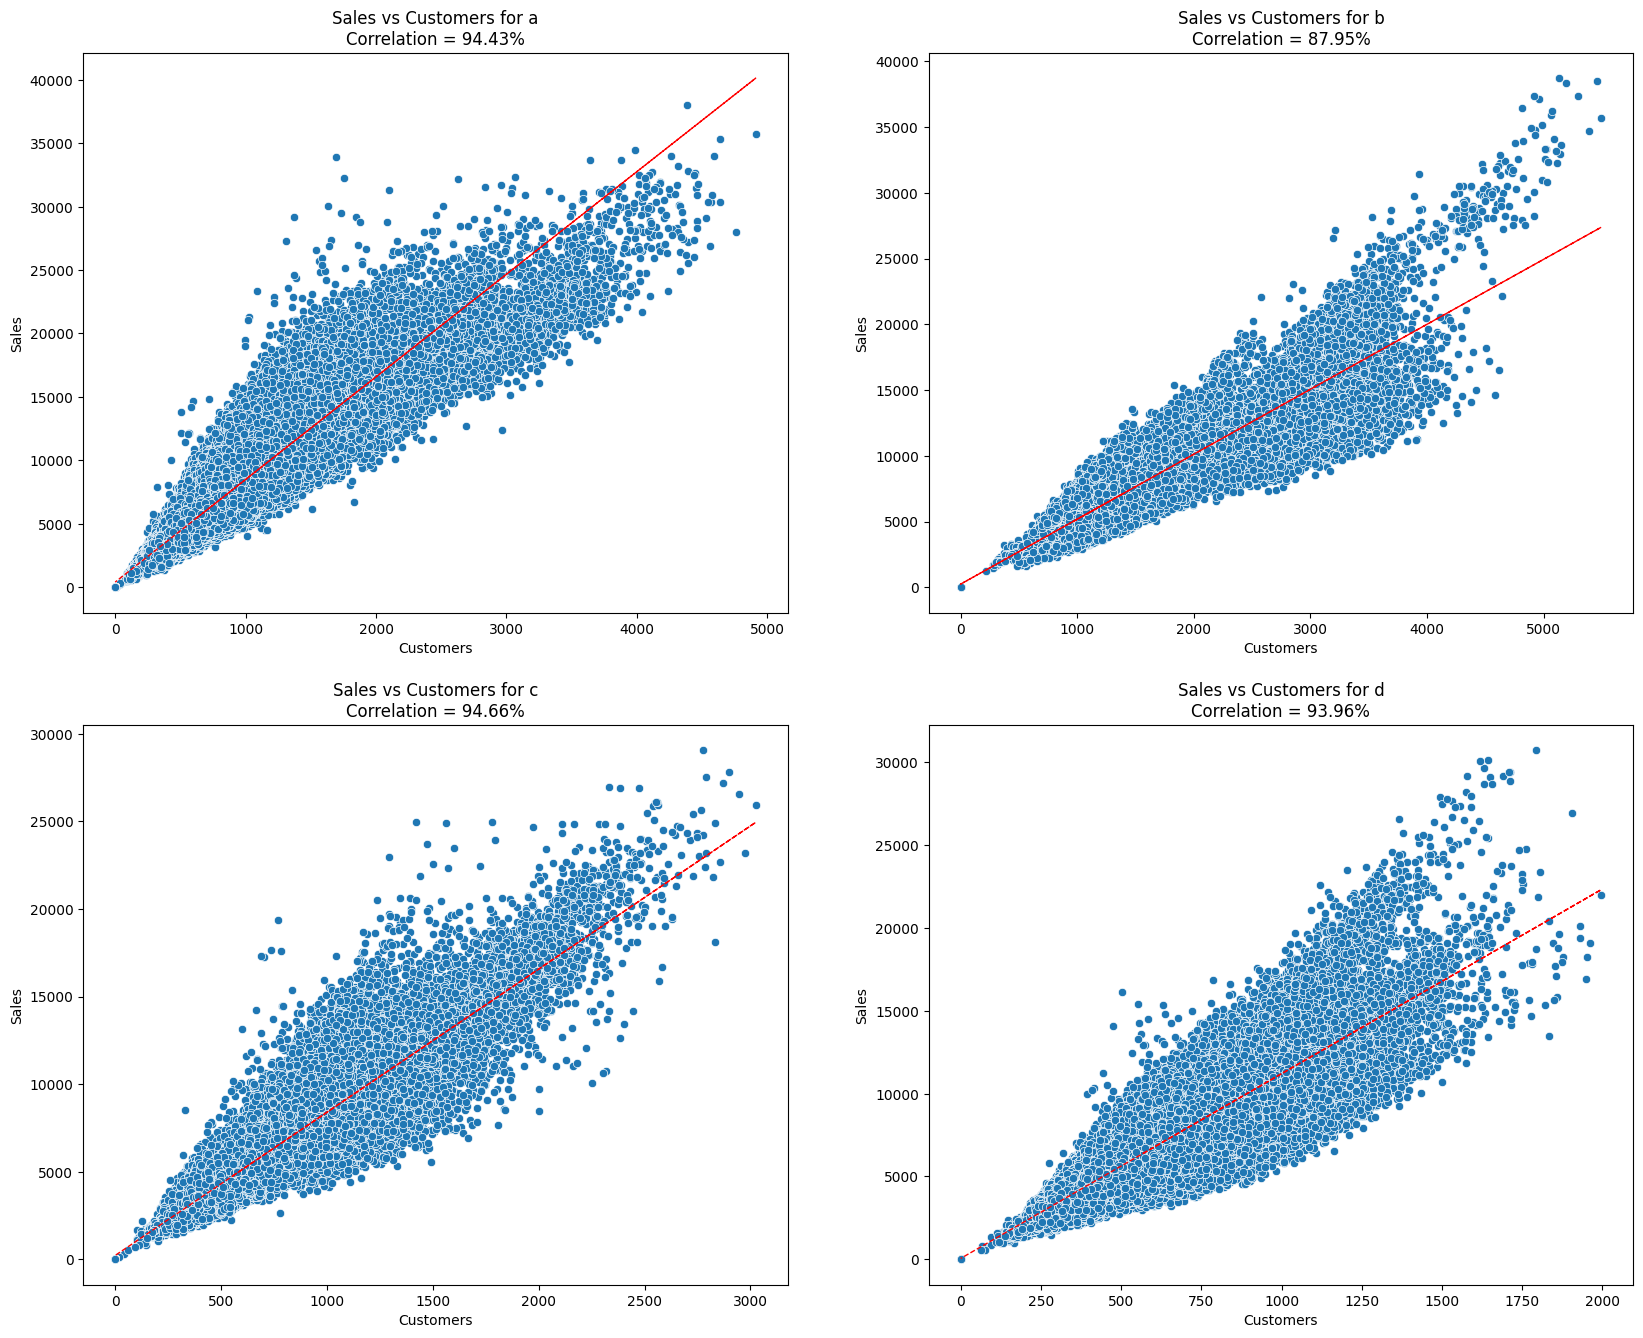

In [134]:
# generate scatter plots to check the linearity between sales and customers for each store type
scatter_plot_bw_sales_customers_with_feature_unique_values(rossmann_df, 'StoreType')

Lets check if there is still ouliers in the data.

Outliers in sales in store type a : 14940 (2.71%)
Outliers in sales in store type b : 247 (1.56%)
Outliers in sales in store type c : 3077 (2.25%)
Outliers in sales in store type d : 5549 (1.77%)


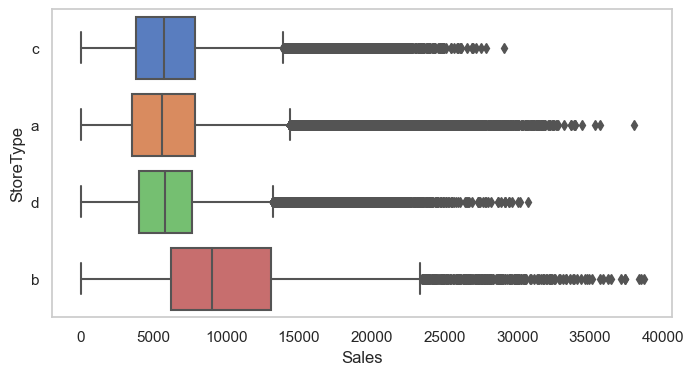

In [135]:
# get unique values of store types
store_types = sorted(rossmann_df['StoreType'].unique().tolist())

# generate box plots of customers for each unique value in each store type
generate_horizontal_box_plot(rossmann_df, 'Sales', 'StoreType')

# count and percentage of outliers in each store type
for store_type in store_types:
  count, perc = get_outlier_count_and_percentage(rossmann_df[rossmann_df['StoreType'] == store_type], 'Sales')
  print(f"Outliers in sales in store type {store_type} : {count} ({perc}%)")

Outliers in customers in store type a : 17063 (3.09%)
Outliers in customers in store type b : 19 (0.12%)
Outliers in customers in store type c : 2884 (2.11%)
Outliers in customers in store type d : 4136 (1.32%)


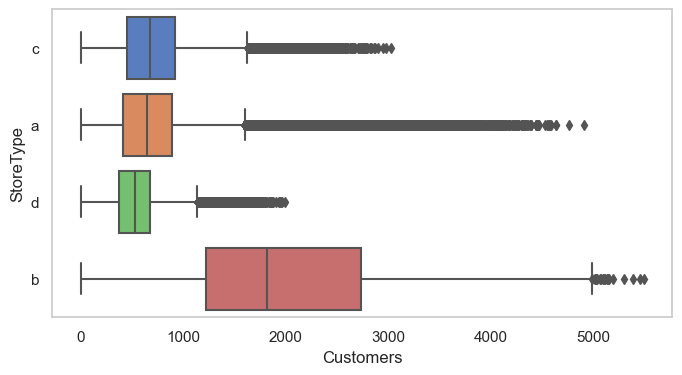

In [136]:
# generate box plots of customers for each unique value in each store type
generate_horizontal_box_plot(rossmann_df, 'Customers', 'StoreType')

# count and percentage of outliers in each store type
for store_type in store_types:
  count, perc = get_outlier_count_and_percentage(rossmann_df[rossmann_df['StoreType'] == store_type], 'Customers')
  print(f"Outliers in customers in store type {store_type} : {count} ({perc}%)")

There are still outliers present in the data, which are detected using the above box plots. The Sales vs Customers scatter plot has been cleared of outliers and the remaining data maintains a good relationship between sales and customers. So, these outliers are just deviation from usual values and not errors in the measurement. Eliminating them can cause overfitting, so we will keep these outliers.

**Assortment**

Each assortment records sales in different range. So it is more appropriate to detect outliers separately for each assortment.

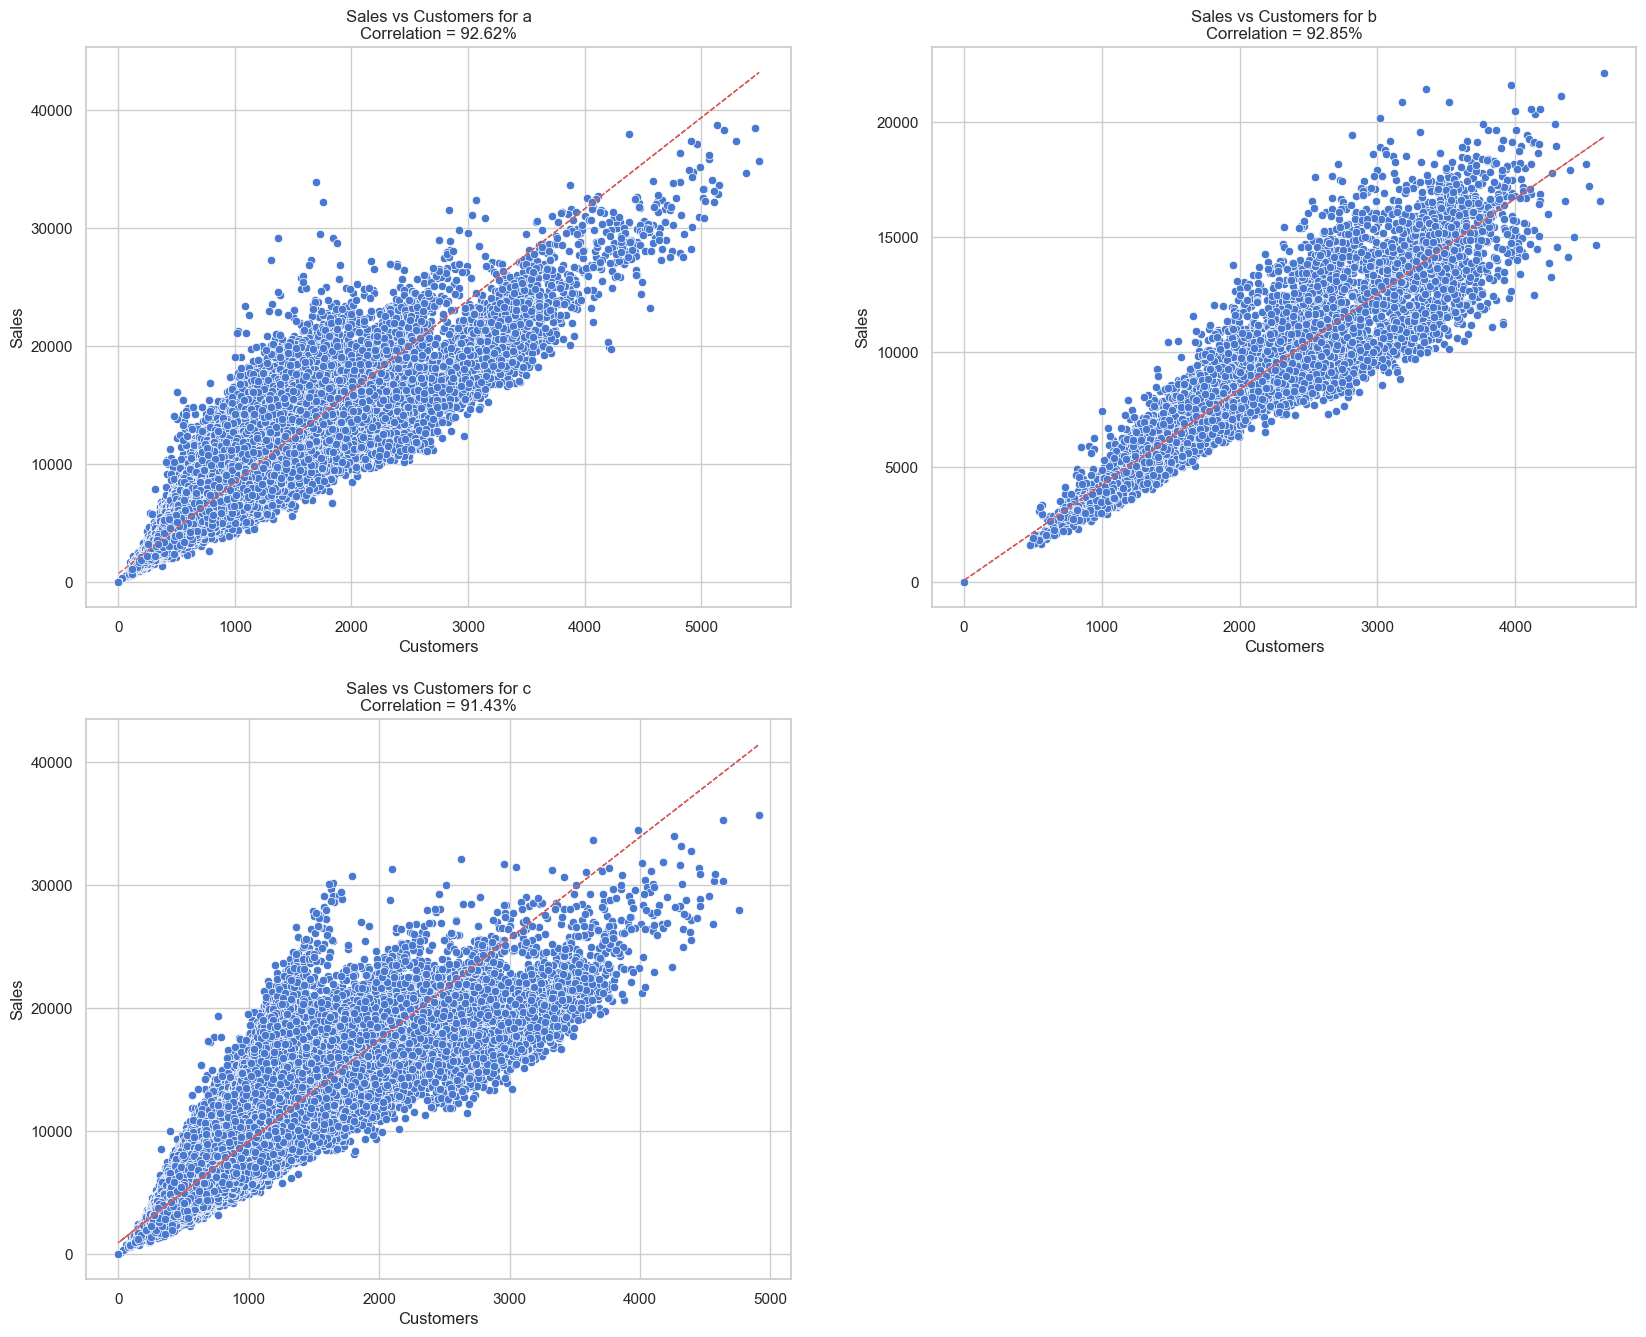

In [137]:
# generate scatter plots to check the linearity between sales and customers for each assortment
scatter_plot_bw_sales_customers_with_feature_unique_values(rossmann_df, 'Assortment')

Outliers have been identified from the scatter plot. Now lets remove them.

In [138]:
# remove outliers with respect to assortments
a_filter = rossmann_df[(rossmann_df['Assortment'] == 'a') & (((rossmann_df['Sales'] > 20000) & (rossmann_df['Customers'] < 1000)) |
                                                             ((rossmann_df['Sales'] > 27500) & (rossmann_df['Customers'] < 2000)) |
                                                             ((rossmann_df['Sales'] > 31000) & (rossmann_df['Customers'] < 3250)) |
                                                              (rossmann_df['Sales'] > 35000))].index
rossmann_df.drop(a_filter, inplace=True)

Now lets check if the outliers are removed

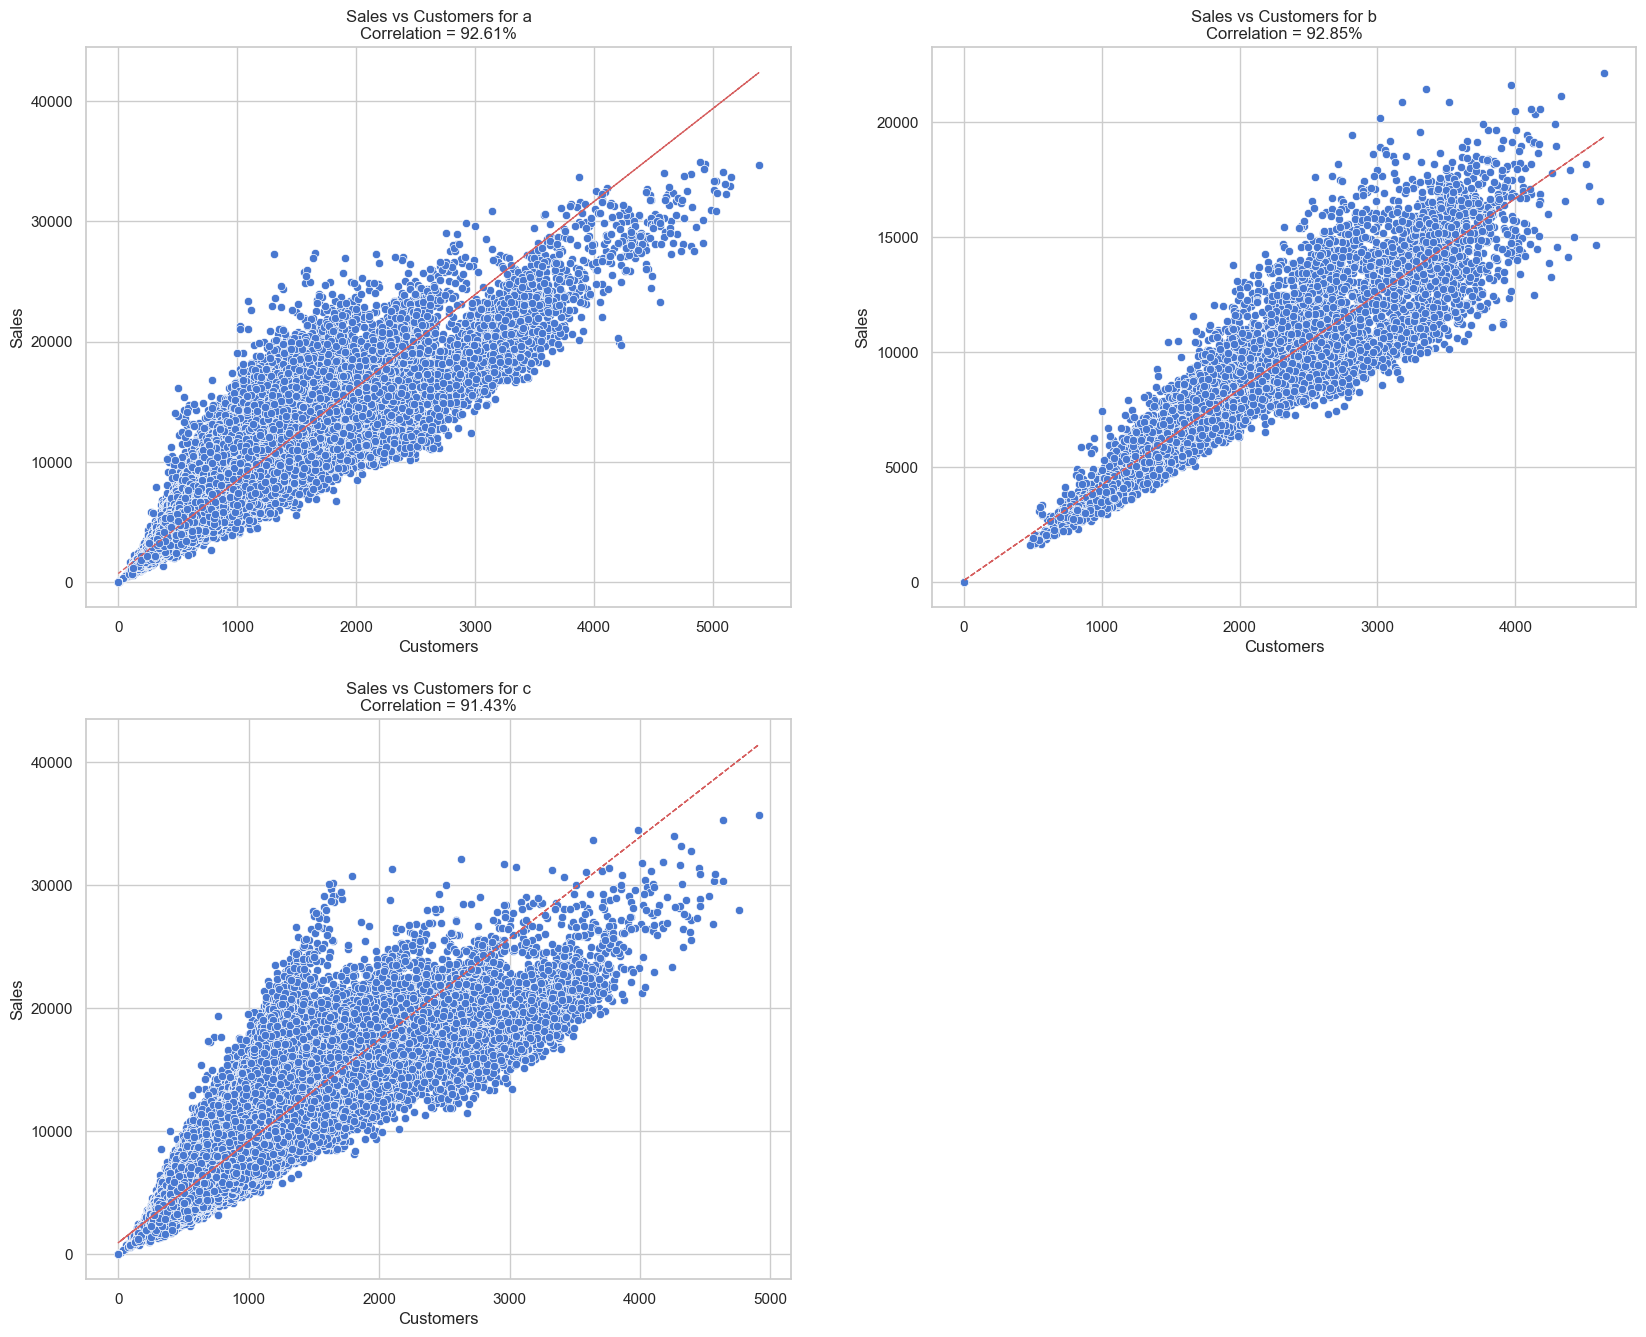

In [139]:
# generate scatter plots to check the linearity between sales and customers for each store type
scatter_plot_bw_sales_customers_with_feature_unique_values(rossmann_df, 'Assortment')

Lets check if there is still ouliers in the data.

Outliers in sales in assortment a : 12384 (2.3%)
Outliers in sales in assortment b : 13 (0.16%)
Outliers in sales in assortment c : 13735 (2.91%)


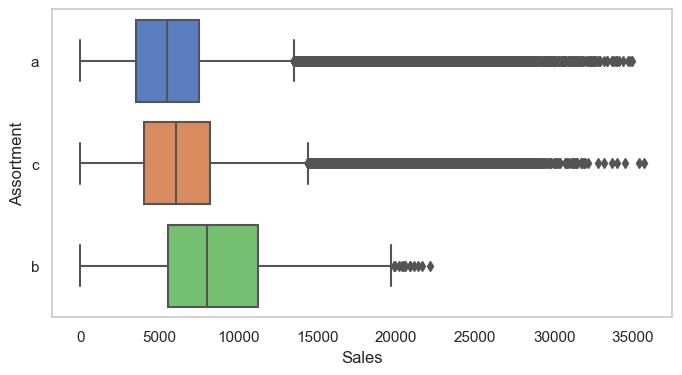

In [140]:
# get unique values of assortment
assortments = sorted(rossmann_df['Assortment'].unique().tolist())

# generate box plots of customers for each unique value in each store type
generate_horizontal_box_plot(rossmann_df, 'Sales', 'Assortment')

# count and percentage of outliers in each store type
for assortment in assortments:
  count, perc = get_outlier_count_and_percentage(rossmann_df[rossmann_df['Assortment'] == assortment], 'Sales')
  print(f"Outliers in sales in assortment {assortment} : {count} ({perc}%)")

Outliers in customers in assortment a : 15624 (2.91%)
Outliers in customers in assortment b : 2 (0.02%)
Outliers in customers in assortment c : 17824 (3.78%)


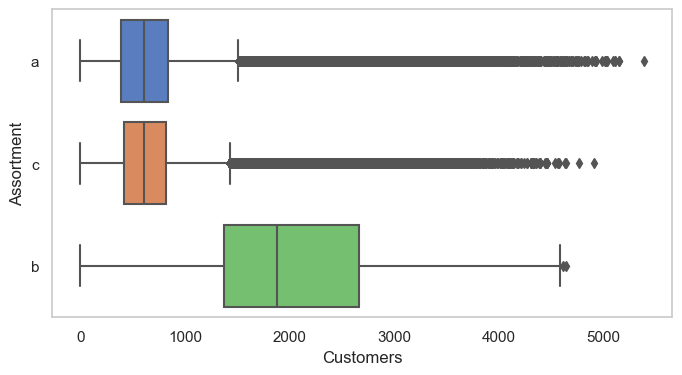

In [141]:
# generate box plots of customers for each unique value in each store type
generate_horizontal_box_plot(rossmann_df, 'Customers', 'Assortment')

# count and percentage of outliers in each store type
for assortment in assortments:
  count, perc = get_outlier_count_and_percentage(rossmann_df[rossmann_df['Assortment'] == assortment], 'Customers')
  print(f"Outliers in customers in assortment {assortment} : {count} ({perc}%)")

There are still outliers present in the data, which are detected using the above box plots. The Sales vs Customers scatter plot has been cleared of outliers and the remaining data maintains a good relationship between sales and customers. So, these outliers are just deviation from usual values and not errors in the measurement. Eliminating them can cause overfitting, so we will keep these outliers.

### Competition Distance

Lets check for outliers in competition distance with a box plot.

Outliers in competition distance : 99158 (9.75%)


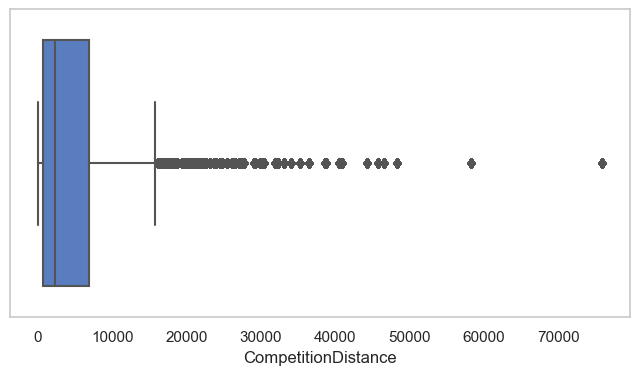

In [142]:
# generate a box plot for competition distance
generate_horizontal_box_plot(rossmann_df, 'CompetitionDistance')

# count and percentage of outliers in competition distance
count, perc = get_outlier_count_and_percentage(rossmann_df, 'CompetitionDistance')
print(f"Outliers in competition distance : {count} ({perc}%)")

Almost 10% of data are outliers and removing them will cause the loss of useful information. What we can do is eliminate only a certain portion of outliers.

There are three options for the section of outliers that we can remove:
1. Competition distance > 55000
2. Competition distance > 44000
3. Competition distance > 37500

Lets check how much data will be removed in all of these options and find which option will remove enough outliers with minimal loss of information.

In [143]:
# count and percentage of data above different values
for limit in (55000, 44000, 37500):
  count = rossmann_df[rossmann_df['CompetitionDistance'] > limit].shape[0]
  perc = round(count/rossmann_df.shape[0]*100, 2)
  print(f"Count & percentage of data above {limit} : {count} ({perc}%)")

Count & percentage of data above 55000 : 1884 (0.19%)
Count & percentage of data above 44000 : 5652 (0.56%)
Count & percentage of data above 37500 : 9420 (0.93%)


We can choose the 3rd option since it clears the most outliers without losing much data.

In [144]:
# remove outliers
rossmann_df.drop(rossmann_df[rossmann_df['CompetitionDistance'] > 37500].index, inplace=True)

Outliers in competition distance : 95022 (9.43%)


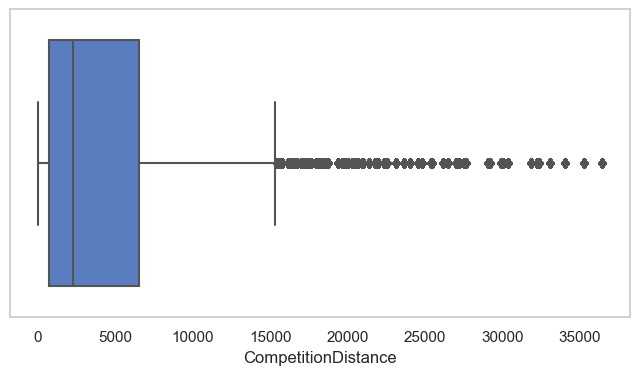

In [145]:
# generate a box plot for competition distance
generate_horizontal_box_plot(rossmann_df, 'CompetitionDistance')

# count and percentage of outliers in competition distance
count, perc = get_outlier_count_and_percentage(rossmann_df, 'CompetitionDistance')
print(f"Outliers in competition distance : {count} ({perc}%)")

## Feature Transformation

Transformation of numerical features is important because algorithms like linear regression, which assumes normal distribution, performs better when features are close to Normal Distribution.

Lets check whether all important numerical features have a normal distribution.

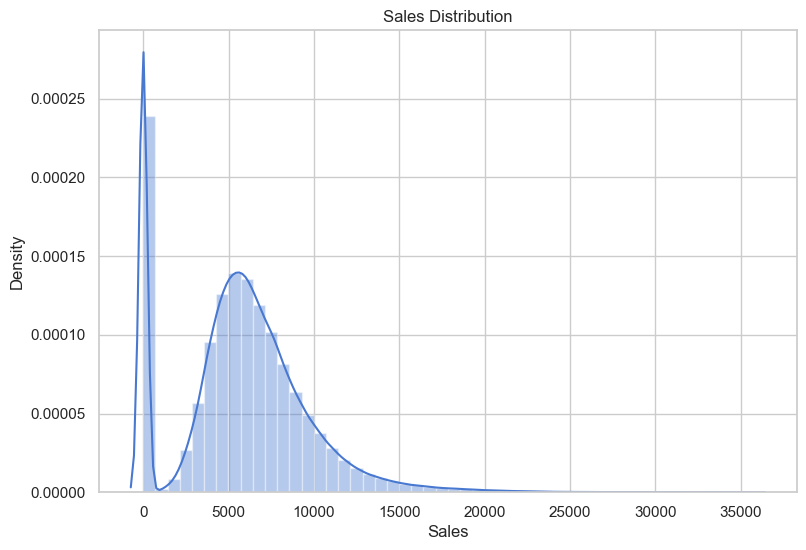

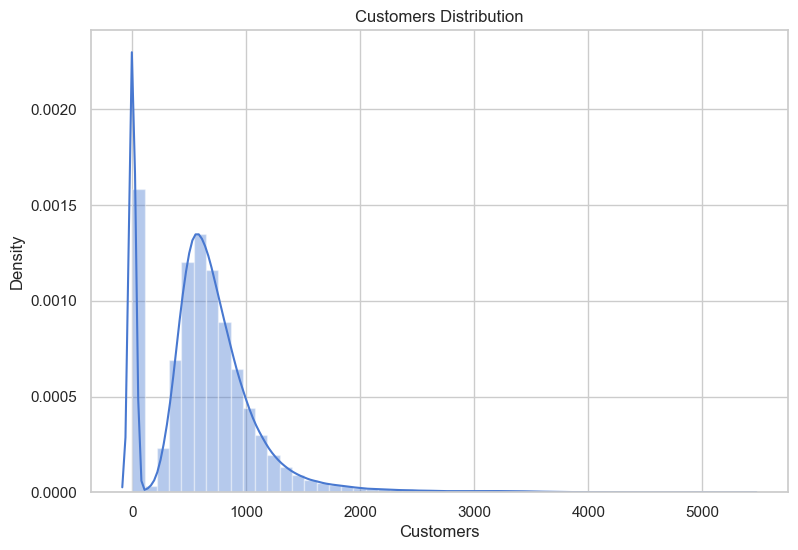

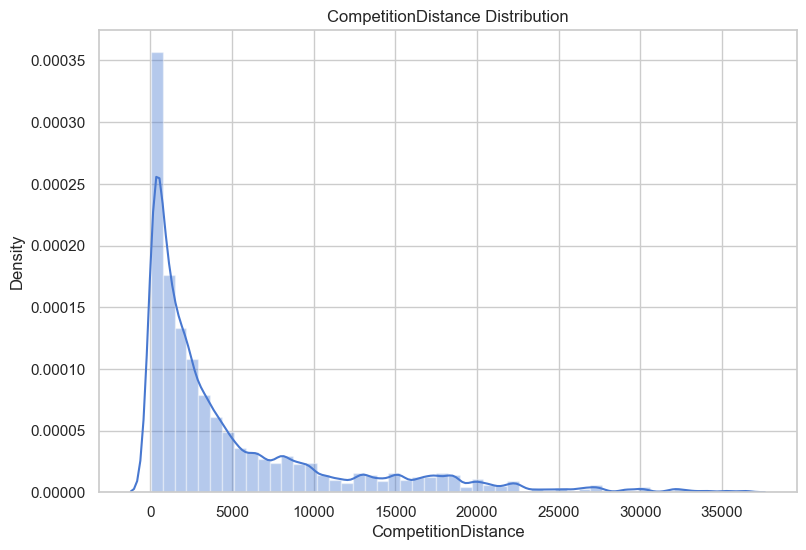

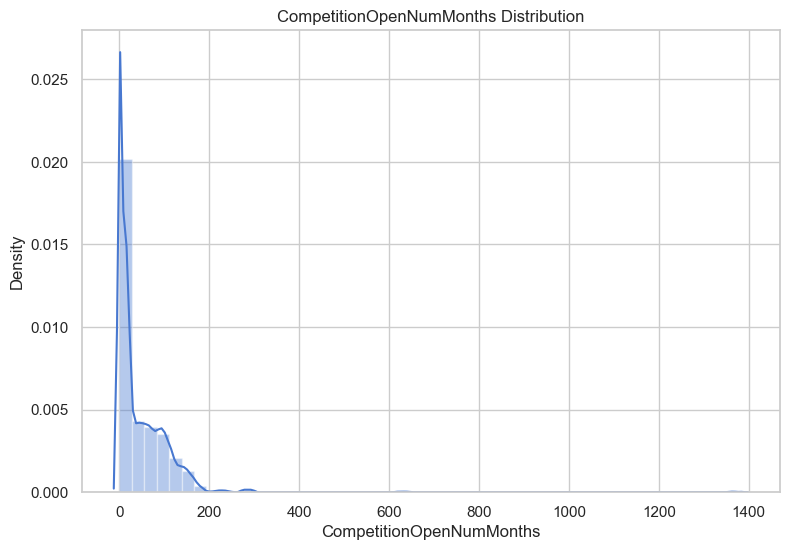

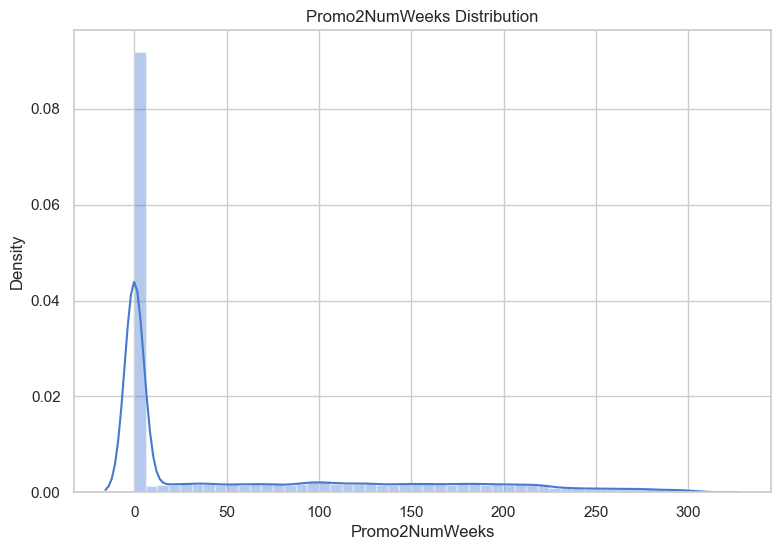

In [146]:
# numerical features
numerical_features = ['Sales', 'Customers', 'CompetitionDistance', 'CompetitionOpenNumMonths', 'Promo2NumWeeks']

# generate density plot for numerical features
for feature in numerical_features:
  plt.figure(figsize=(9, 6))
  sns.distplot(rossmann_df[feature]).set(title=f'{feature} Distribution')
  plt.show()

All these features are positively skewed but linear regression assumes normal distribution. So, they must be transformed to normal distribution before forecasting sales. 

Sales, customers,  competition open number of months and promo 2 number of weeks have zero values while competition distance has only positive values. So sales, customers, competition open number of months and promo 2 number of weeks are square root transformed and competition distance is log transformed.

In [147]:
# square root transformation of sales, customers, competition open number of months and promo 2 number of weeks
rossmann_df['Sales'] = np.sqrt(rossmann_df['Sales'])
rossmann_df['Customers'] = np.sqrt(rossmann_df['Customers'])
rossmann_df['CompetitionOpenNumMonths'] = np.sqrt(rossmann_df['CompetitionOpenNumMonths'])
rossmann_df['Promo2NumWeeks'] = np.sqrt(rossmann_df['Promo2NumWeeks'])

# log transformation of competition distance
rossmann_df['CompetitionDistance'] = np.log(rossmann_df['CompetitionDistance'])

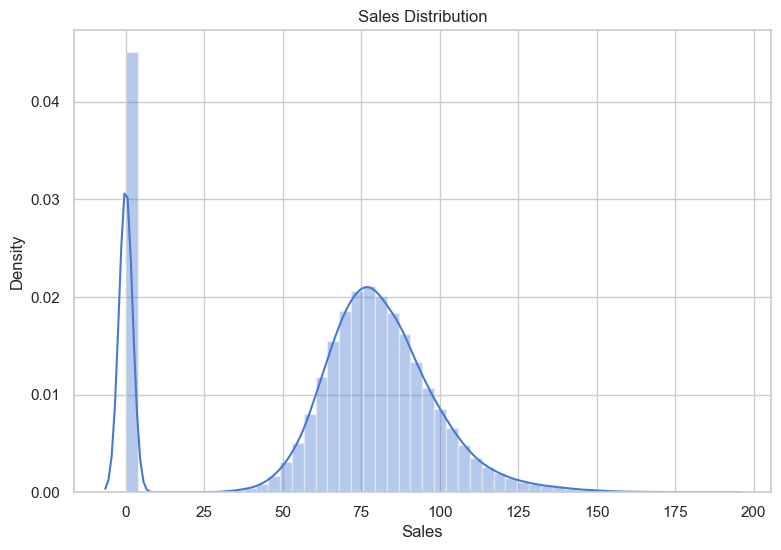

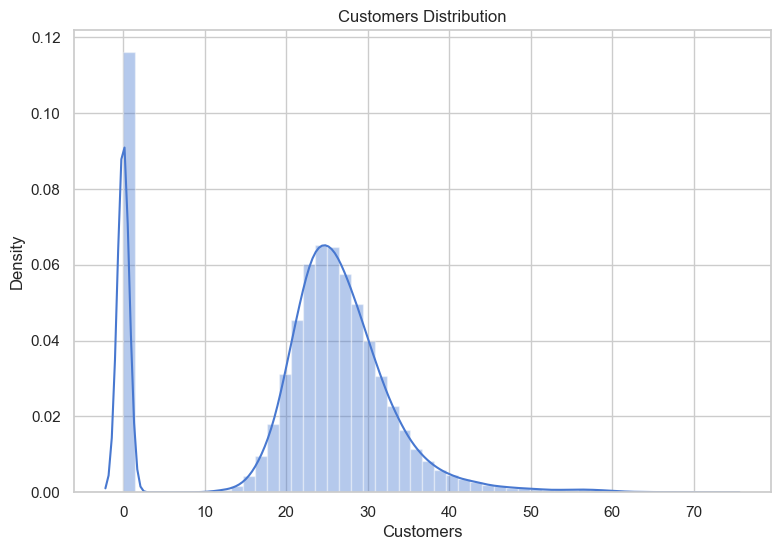

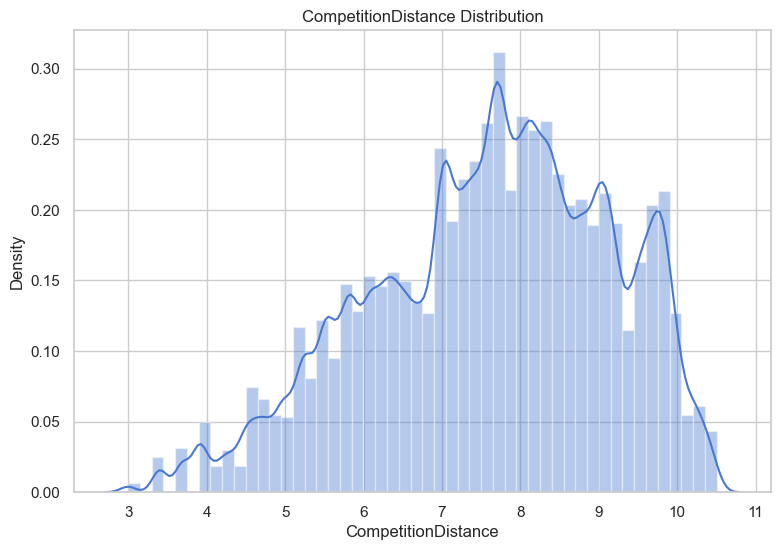

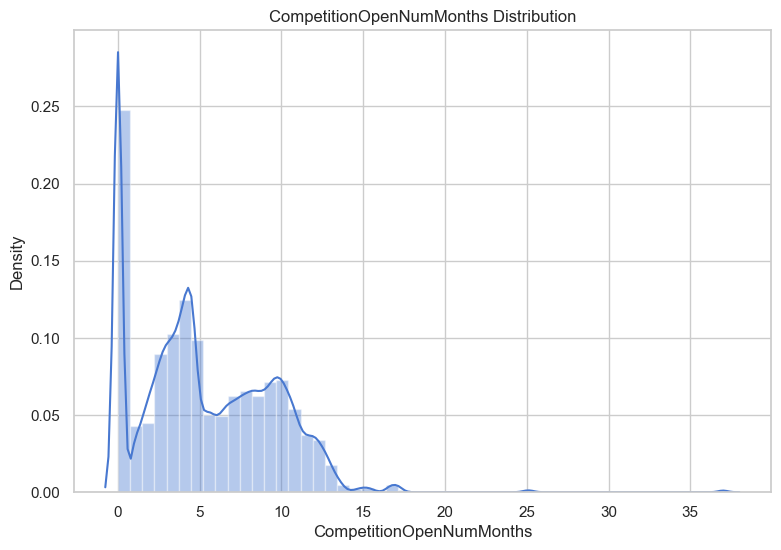

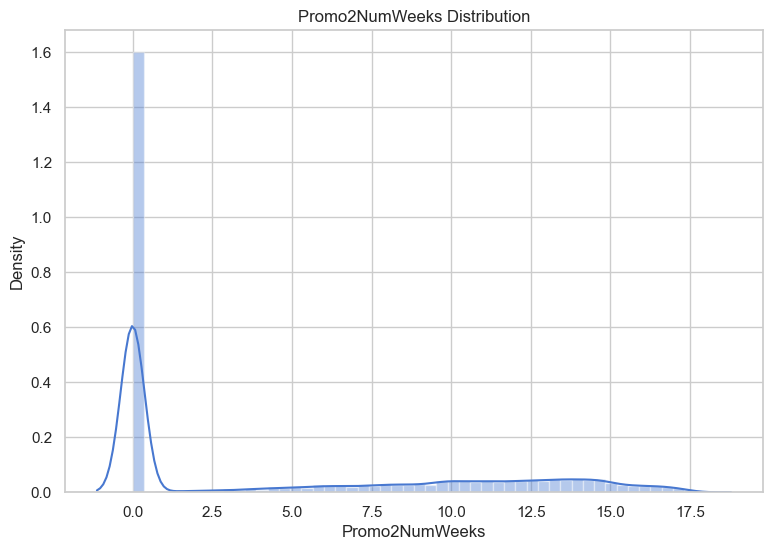

In [148]:
# numerical features
numerical_features = ['Sales', 'Customers', 'CompetitionDistance', 'CompetitionOpenNumMonths', 'Promo2NumWeeks']

# generate density plot for numerical features
for feature in numerical_features:
  plt.figure(figsize=(9, 6))
  sns.distplot(rossmann_df[feature]).set(title=f'{feature} Distribution')
  plt.show()

## Categorical Feature Encoding

Most algorithms cannot handle the categorical variables unless they are converted into a numerical value. So, lets encode DayOfWeek, WeekOfYear, StoreType, Assortment & PromoInterval.

In [149]:
# binary encoding day of week
bin = ce.BinaryEncoder(cols=['DayOfWeek']).fit_transform(rossmann_df['DayOfWeek'])
rossmann_df = pd.concat([rossmann_df, bin], axis=1)
rossmann_df.drop('DayOfWeek', axis=1, inplace=True)

# binary encoding week of year
bin = ce.BinaryEncoder(cols=['WeekOfYear']).fit_transform(rossmann_df['WeekOfYear'])
rossmann_df = pd.concat([rossmann_df, bin], axis=1)
rossmann_df.drop('WeekOfYear', axis=1, inplace=True)

In [150]:
# one hot encoding store type and assortment
ohe = OneHotEncoder(sparse=False, dtype=int)
ohe.fit(rossmann_df[['StoreType', 'Assortment']])
encoded_features = list(ohe.get_feature_names_out(['StoreType', 'Assortment']))
rossmann_df[encoded_features] = ohe.transform(rossmann_df[['StoreType', 'Assortment']])
rossmann_df.drop(['StoreType', 'Assortment'], axis=1, inplace=True)

In [151]:
# dummying promo interval
rossmann_df = pd.get_dummies(rossmann_df, columns=['PromoInterval'])

To overcome dummy variable trap, one resultant feature from each encoded feature must be removed. We can use correlation matrix to decide which features to remove.

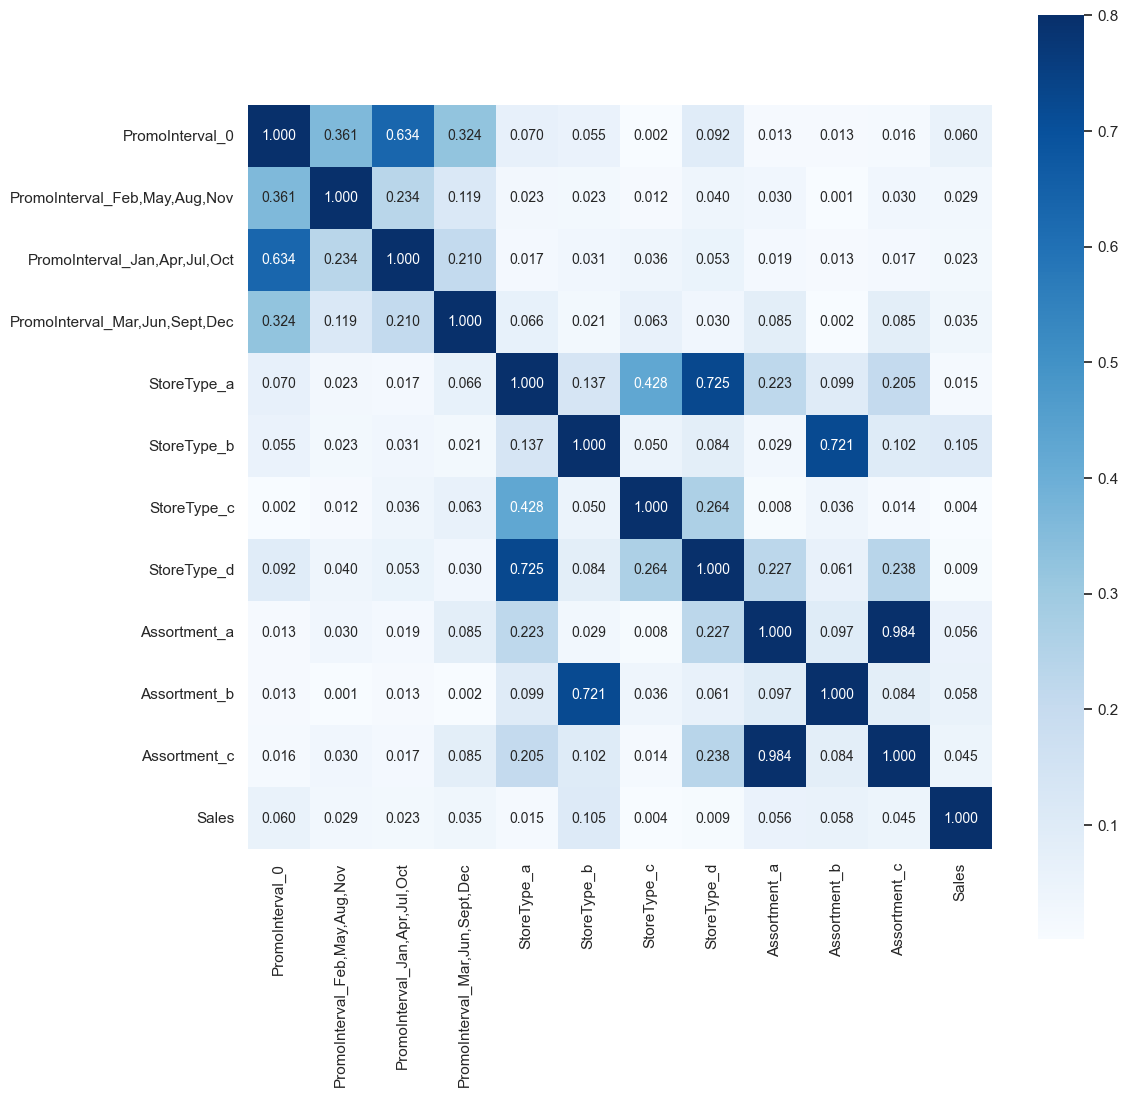

In [152]:
# find the correlation between encoded features & Sales
corr_mat = rossmann_df.loc[:, ['PromoInterval_0', 'PromoInterval_Feb,May,Aug,Nov', 'PromoInterval_Jan,Apr,Jul,Oct', 'PromoInterval_Mar,Jun,Sept,Dec', 
                               'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_a', 'Assortment_b', 'Assortment_c', 'Sales']].corr().abs()
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corr_mat, annot = True, fmt='.3f', annot_kws={'size': 10},  vmax=.8, square=True, cmap="Blues");

PromoInterval_Jan,Apr,Jul,Oct, StoreType_c & Assortment_b have the least correlation to Sales. So, they are removed.

In [153]:
# drop PromoInterval_Jan,Apr,Jul,Oct, StoreType_c & Assortment_b
rossmann_df.drop(['PromoInterval_Jan,Apr,Jul,Oct', 'StoreType_c', 'Assortment_b'], axis=1, inplace=True)

In [154]:
# exploring the head of the resultant dataframe
rossmann_df.head()

Sales  Customers  Open  Promo  StateHoliday  SchoolHoliday  \
0   72.546537  23.558438     1      1             0              1   
1   77.871689  25.000000     1      1             0              1   
2   91.181138  28.653098     1      1             0              1   
3  118.300465  38.704005     1      1             0              1   
4   69.440622  23.643181     1      1             0              1   

   CompetitionDistance  CompetitionOpenNumMonths  Promo2NumWeeks  DayOfWeek_0  \
0             7.146772                  9.055385        0.000000            0   
1             6.345636                  9.591663       16.673332            0   
2             9.556055                 10.148892       15.000000            0   
3             6.429719                  8.366600        0.000000            0   
4            10.305948                  1.732051        0.000000            0   

   ...  WeekOfYear_4  WeekOfYear_5  StoreType_a  StoreType_b  StoreType_d  \
0  ...             0             1            0            0            0   
1  ...             0             1            1            0            0   
2  ...             0             1            1            0            0   
3  ...             0             1            0            0            0   
4  ...             0             1            1            0            0   

   Assortment_a  Assortment_c  PromoInterval_0  PromoInterval_Feb,May,Aug,Nov  \
0             1             0                1                              0   
1             1             0                0                              0   
2             1             0                0                              0   
3             0             1                1                              0   
4             1             0                1                              0   

   PromoInterval_Mar,Jun,Sept,Dec  
0                               0  
1                               0  
2                               0  
3                               0  
4                               0  

[5 rows x 26 columns]

# Modelling

## Train-Test Split

First, we will separate input features and target feature. Lets also remove customers and promo since tfor the period which is under consideration for forecasting, they won't be available until the mentioned period is over.

In [155]:
# independant features (input)
X = rossmann_df.drop(['Sales', 'Customers', 'Promo'], axis=1)

# dependant feature (target)
y = rossmann_df['Sales']

Now, lets split them into training and test data with 25% test data.

In [156]:
# split the datasets to training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)
print(X_train.shape)
print(X_test.shape)

(755786, 23)
(251929, 23)


In [157]:
# create a dataframe to store metrics related to models
metrics_table = pd.DataFrame(columns=['Regression_Model', 'Train_R2', 'Test_R2', 'Train_RMSE', 'Test_RMSE', 'Train_RMSPE', 'Test_RMSPE'])

## Model Training

### Linear Regression

In [158]:
# train data with linear regression
linear_reg = LinearRegression()
liner_reg_model = Pipeline([('scaler', StandardScaler()), ('linear_reg', linear_reg)])
liner_reg_model.fit(X_train, y_train)

# predict the train and test data
y_train_pred = liner_reg_model.predict(X_train)
y_test_pred = liner_reg_model.predict(X_test)

In [159]:
# model evaluation
model_evaluation = calculate_model_metrics(y_train, y_train_pred, y_test, y_test_pred)

# print the results of model evaluation
print(f"Training Data\nR2    : {model_evaluation['Train_R2']}\nRMSE  : {model_evaluation['Train_RMSE']}\nRMSPE : {model_evaluation['Train_RMSPE']}%")
print(f"\nTesting Data\nR2    : {model_evaluation['Test_R2']}\nRMSE  : {model_evaluation['Test_RMSE']}\nRMSPE : {model_evaluation['Test_RMSPE']}%")

# add metrics to metrics table
metrics_table.loc[len(metrics_table.index)] = ['Linear', model_evaluation['Train_R2'], model_evaluation['Test_R2'], 
                                                         model_evaluation['Train_RMSE'], model_evaluation['Test_RMSE'], 
                                                         model_evaluation['Train_RMSPE'], model_evaluation['Test_RMSPE']]

Training Data
R2    : 0.8082934463217293
RMSE  : 15.12828619068261
RMSPE : 22.36815944213766%

Testing Data
R2    : 0.8067043100124811
RMSE  : 15.162202125577181
RMSPE : 22.364953692748024%


In [160]:
# actual vs predicted target data
regression_Dataframe = pd.DataFrame(zip(y_test, y_test_pred), columns = ['actual', 'pred'])
regression_Dataframe

actual       pred
0       103.609845  79.634001
1         0.000000   4.365272
2       102.810505  84.610112
3         0.000000   5.864066
4        81.780193  85.391429
...            ...        ...
251924   85.976741  85.225983
251925   85.445889  75.740237
251926  105.214068  81.097523
251927    0.000000   1.057851
251928    0.000000  -4.580792

[251929 rows x 2 columns]

### Ridge Regression with Hyperparameter Tuning

In [161]:
# train data with ridge regression
ridge = Ridge()
ridge_model = Pipeline([('scaler', StandardScaler()), ('ridge', ridge)])
parameters = {'ridge__alpha':[1e-8, 1e-5, 1e-4, 1e-3, 1e-2, 1, 5]}

# GridSearchCV is used for hyperparameter tuning because Ridge() have only one hyperparameter
# cv=3 since dataset is large
ridge_reg_model = GridSearchCV(ridge_model, parameters, scoring='neg_mean_squared_error', cv=3)
ridge_reg_model.fit(X_train, y_train)

# print the best parameter values and negative mean squared error
print("The best parameters for ridge regression: ")
for key, value in ridge_reg_model.best_params_.items():
  print(f"{key}={value}")
print(f"\nNegative mean squared error: {ridge_reg_model.best_score_}")

# predict the train and test data
y_train_pred = ridge_reg_model.predict(X_train)
y_test_pred = ridge_reg_model.predict(X_test)

The best parameters for ridge regression: 
ridge__alpha=5

Negative mean squared error: -228.88712156820193


In [162]:
# model evaluation
model_evaluation = calculate_model_metrics(y_train, y_train_pred, y_test, y_test_pred)

# print the results of model evaluation
print(f"Training Data\nR2    : {model_evaluation['Train_R2']}\nRMSE  : {model_evaluation['Train_RMSE']}\nRMSPE : {model_evaluation['Train_RMSPE']}%")
print(f"\nTesting Data\nR2    : {model_evaluation['Test_R2']}\nRMSE  : {model_evaluation['Test_RMSE']}\nRMSPE : {model_evaluation['Test_RMSPE']}%")

# add metrics to metrics table
metrics_table.loc[len(metrics_table.index)] = ['Ridge', model_evaluation['Train_R2'], model_evaluation['Test_R2'], 
                                                        model_evaluation['Train_RMSE'], model_evaluation['Test_RMSE'], 
                                                        model_evaluation['Train_RMSPE'], model_evaluation['Test_RMSPE']]

Training Data
R2    : 0.8082934457146809
RMSE  : 15.12828621463485
RMSPE : 22.36815947755261%

Testing Data
R2    : 0.8067043314437232
RMSE  : 15.162201285038952
RMSPE : 22.36495245291502%


In [163]:
# actual vs predicted target data
regression_Dataframe = pd.DataFrame(zip(y_test, y_test_pred), columns = ['actual', 'pred'])
regression_Dataframe

actual       pred
0       103.609845  79.633727
1         0.000000   4.365741
2       102.810505  84.610183
3         0.000000   5.864193
4        81.780193  85.391559
...            ...        ...
251924   85.976741  85.226027
251925   85.445889  75.740010
251926  105.214068  81.097566
251927    0.000000   1.058404
251928    0.000000  -4.580307

[251929 rows x 2 columns]

### Lasso Regression with Hyperparameter Tuning

In [164]:
# train data with lasso regression
lasso = Lasso()
lasso_model = Pipeline([('scaler', StandardScaler()), ('lasso', lasso)])
parameters = {'lasso__alpha':[1e-8, 1e-5, 1e-4, 1e-3, 1e-2, 1, 5]}

# GridSearchCV is used for hyperparameter tuning because Lasso() have only one hyperparameter
# cv=3 since dataset is large
lasso_reg_model = GridSearchCV(lasso_model, parameters, scoring='neg_mean_squared_error', cv=3)
lasso_reg_model.fit(X_train, y_train)

# print the best parameter values and negative mean squared error
print("The best parameters for lasso regression: ")
for key, value in lasso_reg_model.best_params_.items():
  print(f"{key}={value}")
print(f"\nNegative mean squared error: {lasso_reg_model.best_score_}")

# predict the train and test data
y_train_pred = lasso_reg_model.predict(X_train)
y_test_pred = lasso_reg_model.predict(X_test)

The best parameters for lasso regression: 
lasso__alpha=0.0001

Negative mean squared error: -228.8871176512287


In [165]:
# model evaluation
model_evaluation = calculate_model_metrics(y_train, y_train_pred, y_test, y_test_pred)

# print the results of model evaluation
print(f"Training Data\nR2    : {model_evaluation['Train_R2']}\nRMSE  : {model_evaluation['Train_RMSE']}\nRMSPE : {model_evaluation['Train_RMSPE']}%")
print(f"\nTesting Data\nR2    : {model_evaluation['Test_R2']}\nRMSE  : {model_evaluation['Test_RMSE']}\nRMSPE : {model_evaluation['Test_RMSPE']}%")

# add metrics to metrics table
metrics_table.loc[len(metrics_table.index)] = ['Lasso', model_evaluation['Train_R2'], model_evaluation['Test_R2'], 
                                                        model_evaluation['Train_RMSE'], model_evaluation['Test_RMSE'], 
                                                        model_evaluation['Train_RMSPE'], model_evaluation['Test_RMSPE']]

Training Data
R2    : 0.8082934435156447
RMSE  : 15.128286301401964
RMSPE : 22.368159605843456%

Testing Data
R2    : 0.8067043984466409
RMSE  : 15.162198657168862
RMSPE : 22.364948576684355%


In [166]:
# actual vs predicted target data
regression_Dataframe = pd.DataFrame(zip(y_test, y_test_pred), columns = ['actual', 'pred'])
regression_Dataframe

actual       pred
0       103.609845  79.633414
1         0.000000   4.365230
2       102.810505  84.609769
3         0.000000   5.864426
4        81.780193  85.390941
...            ...        ...
251924   85.976741  85.225212
251925   85.445889  75.740230
251926  105.214068  81.098278
251927    0.000000   1.057754
251928    0.000000  -4.580975

[251929 rows x 2 columns]

### Elastic Net Regression with Hyperparameter Tuning

In [167]:
# train data with elastic net regression
elastic_net = ElasticNet()
elastic_net_model = Pipeline([('scaler', StandardScaler()), ('elastic_net', elastic_net)])
parameters = {
  'elastic_net__alpha':[1e-8, 1e-5, 1e-4, 1e-3, 1e-2, 1, 5], 
  'elastic_net__l1_ratio':[0.3,0.4,0.5,0.6,0.7]
  }

# GridSearchCV is used for hyperparameter tuning because ElasticNet() have only two hyperparameters
# cv=3 since dataset is large
elastic_net_reg_model = GridSearchCV(elastic_net_model, parameters, scoring='neg_mean_squared_error', cv=3)
elastic_net_reg_model.fit(X_train, y_train)

# print the best parameter values and negative mean squared error
print("The best parameters for elastic net regression: ")
for key, value in elastic_net_reg_model.best_params_.items():
  print(f"{key}={value}")
print(f"\nNegative mean squared error: {elastic_net_reg_model.best_score_}")

# predict the train and test data
y_train_pred = elastic_net_reg_model.predict(X_train)
y_test_pred = elastic_net_reg_model.predict(X_test)

The best parameters for elastic net regression: 
elastic_net__alpha=1e-05
elastic_net__l1_ratio=0.3

Negative mean squared error: -228.88712200588154


In [168]:
# model evaluation
model_evaluation = calculate_model_metrics(y_train, y_train_pred, y_test, y_test_pred)

# print the results of model evaluation
print(f"Training Data\nR2    : {model_evaluation['Train_R2']}\nRMSE  : {model_evaluation['Train_RMSE']}\nRMSPE : {model_evaluation['Train_RMSPE']}%")
print(f"\nTesting Data\nR2    : {model_evaluation['Test_R2']}\nRMSE  : {model_evaluation['Test_RMSE']}\nRMSPE : {model_evaluation['Test_RMSPE']}%")

# add metrics to metrics table
metrics_table.loc[len(metrics_table.index)] = ['Elastic Net', model_evaluation['Train_R2'], model_evaluation['Test_R2'], 
                                                              model_evaluation['Train_RMSE'], model_evaluation['Test_RMSE'], 
                                                              model_evaluation['Train_RMSPE'], model_evaluation['Test_RMSPE']]

Training Data
R2    : 0.8082934455641193
RMSE  : 15.12828622057554
RMSPE : 22.36815948633631%

Testing Data
R2    : 0.806704335308143
RMSE  : 15.162201133475516
RMSPE : 22.364952229351903%


In [169]:
# actual vs predicted target data
regression_Dataframe = pd.DataFrame(zip(y_test, y_test_pred), columns = ['actual', 'pred'])
regression_Dataframe

actual       pred
0       103.609845  79.633693
1         0.000000   4.365767
2       102.810505  84.610177
3         0.000000   5.864212
4        81.780193  85.391552
...            ...        ...
251924   85.976741  85.226006
251925   85.445889  75.739997
251926  105.214068  81.097591
251927    0.000000   1.058433
251928    0.000000  -4.580285

[251929 rows x 2 columns]

### Decision Tree Regression with Hyperparameter Tuning

In [170]:
# train data with decision tree regression
decision_tree = DecisionTreeRegressor()
parameters = {'max_depth': [5, 10, None],
              'min_samples_leaf': [1, 2, 5],
              'min_samples_split': [2, 5, 10],
              'max_leaf_nodes': [5, 20, 100],
              'max_features': ['auto', 'sqrt', 'log2']}

# RandomizedSearchCV is used for hyperparameter tuning because DecisionTreeRegressor() have multiple hyperparameters
# cv=3 & n_iter=10 since dataset is large
dt_reg = RandomizedSearchCV(estimator=decision_tree, param_distributions=parameters, n_iter=10, cv=3)
dt_reg.fit(X_train, y_train)

# print the best parameter values and negative mean squared error
print("The best parameters for decision tree regression: ")
for key, value in dt_reg.best_params_.items():
  print(f"{key}={value}")
print(f"\nNegative mean squared error: {dt_reg.best_score_}")

# predict the train and test data
y_train_pred = dt_reg.predict(X_train)
y_test_pred = dt_reg.predict(X_test)

The best parameters for decision tree regression: 
min_samples_split=10
min_samples_leaf=1
max_leaf_nodes=100
max_features=auto
max_depth=None

Negative mean squared error: 0.8366679169764127


In [171]:
# model evaluation
model_evaluation = calculate_model_metrics(y_train, y_train_pred, y_test, y_test_pred)

# print the results of model evaluation
print(f"Training Data\nR2    : {model_evaluation['Train_R2']}\nRMSE  : {model_evaluation['Train_RMSE']}\nRMSPE : {model_evaluation['Train_RMSPE']}%")
print(f"\nTesting Data\nR2    : {model_evaluation['Test_R2']}\nRMSE  : {model_evaluation['Test_RMSE']}\nRMSPE : {model_evaluation['Test_RMSPE']}%")

# add metrics to metrics table
metrics_table.loc[len(metrics_table.index)] = ['Decision Tree', model_evaluation['Train_R2'], model_evaluation['Test_R2'], 
                                                                model_evaluation['Train_RMSE'], model_evaluation['Test_RMSE'], 
                                                                model_evaluation['Train_RMSPE'], model_evaluation['Test_RMSPE']]

Training Data
R2    : 0.837258192374339
RMSE  : 13.938653416488329
RMSPE : 20.60920966849053%

Testing Data
R2    : 0.8356342525653483
RMSE  : 13.981599449823172
RMSPE : 20.623509807876474%


In [172]:
# actual vs predicted target data
regression_Dataframe = pd.DataFrame(zip(y_test, y_test_pred), columns = ['actual', 'pred'])
regression_Dataframe

actual       pred
0       103.609845  84.299420
1         0.000000   0.000000
2       102.810505  88.873962
3         0.000000   0.000000
4        81.780193  81.098058
...            ...        ...
251924   85.976741  86.173311
251925   85.445889  84.299420
251926  105.214068  83.799143
251927    0.000000   0.000000
251928    0.000000   0.000000

[251929 rows x 2 columns]

### Random Forest Regression with Hyperparameter Tuning

In [173]:
# train data with random forest regression
random_forest = RandomForestRegressor()
parameters = {'max_depth': [5, 10, None],
              'min_samples_leaf': [1, 2, 5],
              'min_samples_split': [2, 5, 10],
              'max_leaf_nodes': [5, 20, 100],
              'max_features': ['auto', 'sqrt', 'log2']}

# RandomizedSearchCV is used for hyperparameter tuning because RandomForestRegressor() have multiple hyperparameters
# cv=3 & n_iter=10 since dataset is large
rf_reg = RandomizedSearchCV(estimator=random_forest, param_distributions=parameters, n_iter=10, cv=3)
rf_reg.fit(X_train, y_train)

# print the best parameter values and negative mean squared error
print("The best parameters for random forest regression: ")
for key, value in rf_reg.best_params_.items():
  print(f"{key}={value}")
print(f"\nNegative mean squared error: {rf_reg.best_score_}")

# predict the train and test data
y_train_pred = rf_reg.predict(X_train)
y_test_pred = rf_reg.predict(X_test)

The best parameters for random forest regression: 
min_samples_split=10
min_samples_leaf=2
max_leaf_nodes=100
max_features=log2
max_depth=None

Negative mean squared error: 0.8233774817216805


In [174]:
# model evaluation
model_evaluation = calculate_model_metrics(y_train, y_train_pred, y_test, y_test_pred)

# print the results of model evaluation
print(f"Training Data\nR2    : {model_evaluation['Train_R2']}\nRMSE  : {model_evaluation['Train_RMSE']}\nRMSPE : {model_evaluation['Train_RMSPE']}%")
print(f"\nTesting Data\nR2    : {model_evaluation['Test_R2']}\nRMSE  : {model_evaluation['Test_RMSE']}\nRMSPE : {model_evaluation['Test_RMSPE']}%")

# add metrics to metrics table
metrics_table.loc[len(metrics_table.index)] = ['Random Forest', model_evaluation['Train_R2'], model_evaluation['Test_R2'], 
                                                                model_evaluation['Train_RMSE'], model_evaluation['Test_RMSE'], 
                                                                model_evaluation['Train_RMSPE'], model_evaluation['Test_RMSPE']]

Training Data
R2    : 0.8225588451592691
RMSE  : 14.554538170997356
RMSPE : 21.51983551289876%

Testing Data
R2    : 0.8210782965347666
RMSE  : 14.587561795536184
RMSPE : 21.517332465639292%


In [175]:
# actual vs predicted target data
regression_Dataframe = pd.DataFrame(zip(y_test, y_test_pred), columns = ['actual', 'pred'])
regression_Dataframe

actual       pred
0       103.609845  81.307359
1         0.000000   7.550581
2       102.810505  85.396476
3         0.000000   6.972626
4        81.780193  80.991771
...            ...        ...
251924   85.976741  83.970028
251925   85.445889  77.289536
251926  105.214068  84.295991
251927    0.000000   5.541765
251928    0.000000   4.424290

[251929 rows x 2 columns]

### XGBoost Regression with Hyperparameter Tuning

In [176]:
# train data with XGBoost regression
xgboost = xgb.XGBRegressor(objective='reg:linear', verbosity=0)
parameters = {'max_depth': [2, 5, 10],
              'learning_rate': [0.05, 0.1, 0.2],
              'min_child_weight': [1, 2, 5],
              'gamma': [0, 0.1, 0.3],
              'colsample_bytree': [0.3, 0.5, 0.7]}

# RandomizedSearchCV is used for hyperparameter tuning because XGBRegressor() have multiple hyperparameters
# cv=3 & n_iter=10 since dataset is large
xg_reg = RandomizedSearchCV(estimator=xgboost, param_distributions=parameters, n_iter=10, cv=3)
xg_reg.fit(X_train, y_train)

# print the best parameter values and negative mean squared error
print("The best parameters for XGBoost regression: ")
for key, value in xg_reg.best_params_.items():
  print(f"{key}={value}")
print(f"\nNegative mean squared error: {xg_reg.best_score_}")

# predict the train and test data
y_train_pred = xg_reg.predict(X_train)
y_test_pred = xg_reg.predict(X_test)

The best parameters for XGBoost regression: 
min_child_weight=2
max_depth=10
learning_rate=0.2
gamma=0.1
colsample_bytree=0.7

Negative mean squared error: 0.9603637695414348


In [177]:
# model evaluation
model_evaluation = calculate_model_metrics(y_train, y_train_pred, y_test, y_test_pred)

# print the results of model evaluation
print(f"Training Data\nR2    : {model_evaluation['Train_R2']}\nRMSE  : {model_evaluation['Train_RMSE']}\nRMSPE : {model_evaluation['Train_RMSPE']}%")
print(f"\nTesting Data\nR2    : {model_evaluation['Test_R2']}\nRMSE  : {model_evaluation['Test_RMSE']}\nRMSPE : {model_evaluation['Test_RMSPE']}%")

# add metrics to metrics table
metrics_table.loc[len(metrics_table.index)] = ['XGBoost', model_evaluation['Train_R2'], model_evaluation['Test_R2'], 
                                                          model_evaluation['Train_RMSE'], model_evaluation['Test_RMSE'], 
                                                          model_evaluation['Train_RMSPE'], model_evaluation['Test_RMSPE']]

Training Data
R2    : 0.9626926595797608
RMSE  : 6.673726379479253
RMSPE : 9.86754043702133%

Testing Data
R2    : 0.9601389925247253
RMSE  : 6.885339072955009
RMSPE : 10.156195534799034%


In [178]:
# actual vs predicted target data
regression_Dataframe = pd.DataFrame(zip(y_test, y_test_pred), columns = ['actual', 'pred'])
regression_Dataframe

actual        pred
0       103.609845  103.560570
1         0.000000   -0.814950
2       102.810505  101.220566
3         0.000000   -0.581171
4        81.780193   76.216927
...            ...         ...
251924   85.976741   87.673203
251925   85.445889   81.813530
251926  105.214068   95.048073
251927    0.000000   -0.970936
251928    0.000000   -0.191220

[251929 rows x 2 columns]

## Model Comparison

In [179]:
# print metrics table
metrics_table

Regression_Model  Train_R2   Test_R2  Train_RMSE  Test_RMSE  Train_RMSPE  \
0           Linear  0.808293  0.806704   15.128286  15.162202    22.368159   
1            Ridge  0.808293  0.806704   15.128286  15.162201    22.368159   
2            Lasso  0.808293  0.806704   15.128286  15.162199    22.368160   
3      Elastic Net  0.808293  0.806704   15.128286  15.162201    22.368159   
4    Decision Tree  0.837258  0.835634   13.938653  13.981599    20.609210   
5    Random Forest  0.822559  0.821078   14.554538  14.587562    21.519836   
6          XGBoost  0.962693  0.960139    6.673726   6.885339     9.867540   

   Test_RMSPE  
0   22.364954  
1   22.364952  
2   22.364949  
3   22.364952  
4   20.623510  
5   21.517332  
6   10.156196

R2 score can be used to compare different models and find out which one gives higher accuracy. Higher the R2 score, higher the accuracy.

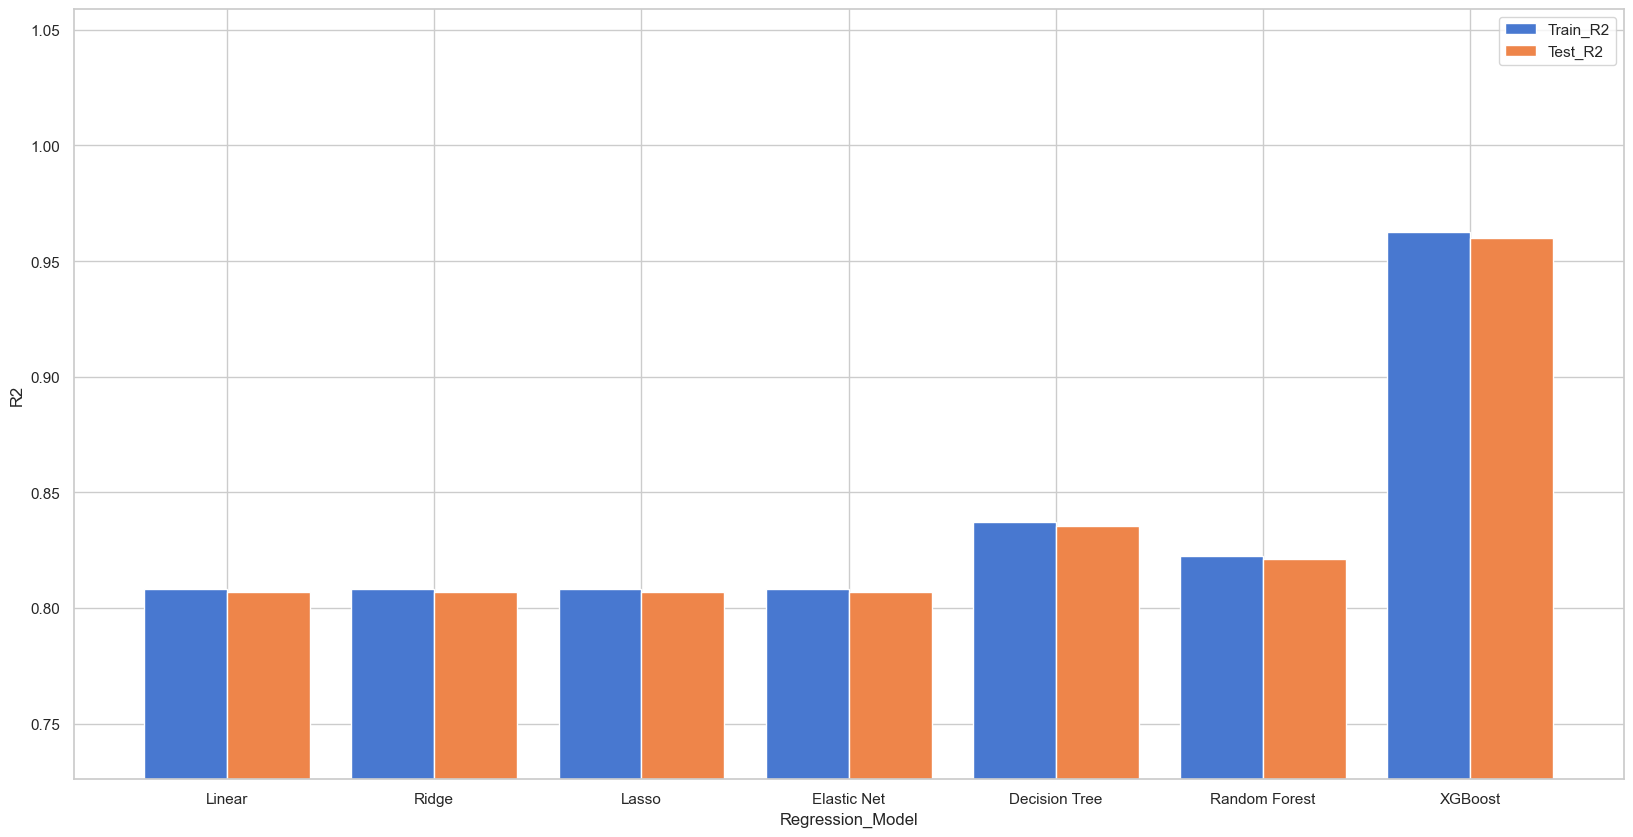

In [180]:
# plot bar graph to show R2 scores
plot_bar_graph_with_three_features(metrics_table, 'Regression_Model', 'Train_R2', 'Test_R2', 'R2')

The model built using XGBoost algorithm has the highest R2 score, followed by the one using random forest and decision tree.

In [182]:
# pickling the scaler for deployment
pickle.dump(dt_reg, open('../models/ml_model.pkl', 'wb'))

# Conclusion

### Conclusions from EDA

1. Mondays have most sales since most of the Sundays are closed.
2. Promotions seem to have a significant effect on sales but not for the number of customers. It is advisable to spend more on promos to get higher returns.
3. Store type b has higher sales and customers per store than other store types. More Store type b must be opened.
4. Assortment b is available only at store type b and it has more sales and customers than any other assortment. More assortment b must be stocked to meet the demands of customers.
5. Weekly sales and customers peak at the mid-December. It may be guessed that people buy drugs in advance just before the shops close for the holiday season.

### Conclusions from Modelling

1. The model built using XGBoost algorithm gives unusually high accuracy. This may lead to overfitting. Therefore, it is advisable to not use this model. 
2. Among the remaining, the model built using decision tree algorithm is the most accurate one. This can be attributed to higher number of categorical features in the data. 
4. Decision tree based algorithms are slightly more accurate than linear regression based algorithms. 